# Example development notebook for `app_predict`

Related wiki page:  
https://github.com/stharrold/demo/wiki/app_predict

In [1]:
cd /opt/demo

/opt/demo


In [2]:
# Import standard packages.
import os
import sys
import time
# Import installed packages.
# Import local packages.
sys.path.insert(0, os.path.join(os.path.curdir, r'demo'))
%reload_ext autoreload
%autoreload 2
import demo
%matplotlib inline

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
print("Timestamp:")
print(time.strftime(r'%Y-%m-%dT%H:%M:%S%Z', time.gmtime()))
print()
print("Versions:")
print("Python:", sys.version_info)
print("demo:", demo.__version__)

Timestamp:
2017-02-27T03:17:41GMT

Versions:
Python: sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)
demo: 0.0.0


In [4]:
!py.test -v --pdb

============================= test session starts ==============================
platform linux -- Python 3.5.2, pytest-2.9.2, py-1.4.31, pluggy-0.3.1 -- /opt/conda/bin/python
cachedir: .cache
rootdir: /opt/demo, inifile: 
collected 8 items 

tests/test__init__.py::test__all__ PASSED
tests/test__init__.py::test__version__ PASSED
tests/test_app_template/test_app_template__init__.py::test__all__ PASSED
tests/test_app_template/test_app_template_main.py::test__all__ PASSED
tests/test_app_template/test_app_template_main.py::test_main PASSED
tests/test_app_template/test_app_template_main.py::test__main__ PASSED
tests/test_app_template/test_template.py::test_prepend_this PASSED
tests/test_utils/test_utils__init__.py::test__all__ PASSED

=========================== 8 passed in 5.51 seconds ===========================


# Development below

## Initialization

### Imports

In [1]:
cd /opt/demo

/opt/demo


In [5]:
# Import standard packages.
import bs4
import collections
import gc
import glob
import io
import logging
import os
import pickle
import requests
import shelve
import subprocess
import sys
import textwrap
import time
import warnings
# Import installed packages.
import geopy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn as sk
import sklearn.cross_validation as sk_cv
import sklearn.cluster as sk_cl
import sklearn.decomposition as sk_dc
import sklearn.ensemble as sk_ens
import sklearn.metrics as sk_met
import sklearn.preprocessing as sk_pre
# Import local packages.
# datascience version: TODO link to GitHub tag v0.0.1.
sys.path.insert(0, os.path.join(os.path.curdir, r'demo'))
%reload_ext autoreload
%autoreload 2
import demo
%matplotlib inline

In [6]:
print("Timestamp:")
print(time.strftime(r'%Y-%m-%dT%H:%M:%S%Z', time.gmtime()))
print()
print("Versions:")
print("Python:", sys.version_info)
print("matplotlib:", mpl.__version__)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("scipy:", scipy.__version__)
print("sklearn:", sk.__version__)
print("seaborn:", sns.__version__)
print("demo:", demo.__version__)

Timestamp:
2017-02-28T07:11:04GMT

Versions:
Python: sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)
matplotlib: 1.5.1
numpy: 1.11.1
pandas: 0.18.1
scipy: 0.17.1
sklearn: 0.17.1
seaborn: 0.7.1
demo: 0.0.0


In [7]:
# State settings.
sns.set() # Set matplot lib styles with seaborn
np.random.seed(seed=1) # Set random state for reproducibility.

# File paths
path_data_dir = os.path.join(os.path.abspath(os.path.curdir), r'demo/app_predict/data')
path_csv = os.path.join(path_data_dir, r'Risky Dealer Case Study Transactions.csv')

# Statistics
# percentiles = [-1.6449 sigma, -1 sigma, mean, +1 sigma, +1.6449 sigma] for normal distribution
# 90.00% confidence interval = (percentiles[0], percentiles[-1])
# 68.27% confidence interval = (percentiles[1], percentiles[-2])
# median = percentiles[2]
percentiles = [0.0500, 0.1587, 0.5000, 0.8413, 0.9500]

# Logger
logger = logging.getLogger()

## Extract, transform, and load

In [8]:
print(r"""`df`: Load and format sales transactions.""")
df_backup = pd.read_csv(path_csv)
df_backup.head()

`df`: Load and format sales transactions.


BuyerID  SellerID  Mileage                VIN SellingLocation    CarMake  \
0   351757    441081    37055  1FAHP3M27CL374352            CAAI       FORD   
1   351757    442235      248  1G1JE6SB7D4103706            DETA  CHEVROLET   
2   351757    436280    39627  1G1PG5SC4C7102274            CAAI  CHEVROLET   
3   351757    436280    50773  1G1PG5SC5C7113820            CAAI  CHEVROLET   
4   351757    434202    54133  1GNKVGED4BJ301146            SVAA  CHEVROLET   

   SalePrice  CarYear    MMR  JDPowersCat    ...     Salvage  OVE  Simulcast  \
0      13000     2012  13050  COMPACT CAR    ...           0    0          0   
1      13900     2013  13600  COMPACT CAR    ...           0    0          0   
2      13800     2012  14050  MIDSIZE CAR    ...           0    0          0   
3      12900     2012  13150  MIDSIZE CAR    ...           0    0          0   
4      17800     2011  18050          SUV    ...           0    0          0   

   InLane  PSIEligible  SaleDate  Autocheck_score  ConditionReport  \
0       0            1  13-07-25         1.000000              NaN   
1       0            1  13-10-24              NaN              NaN   
2       1            1  13-04-18        -2.666667               41   
3       1            1  13-04-18         1.000000               31   
4       1            1  13-02-26        -1.400000               34   

   DSEligible  Returned  
0           1       0.0  
1           1       NaN  
2           1       NaN  
3           1       NaN  
4           1       NaN  

[5 rows x 25 columns]

In [9]:
df = demo.app_predict.predict.etl(df=df_backup)
df = demo.app_predict.predict.create_features(df=df, path_data_dir=path_data_dir)
with pd.option_context('display.max_rows', len(df.dtypes)):
    print(df.dtypes)

BuyerID                                                      object
SellerID                                                     object
Mileage                                                       int64
VIN                                                          object
SellingLocation                                              object
CarMake                                                      object
SalePrice                                                     int64
CarYear                                                       int64
MMR                                                           int64
JDPowersCat                                                  object
LIGHTG                                                        int64
LIGHTY                                                        int64
LIGHTR                                                        int64
PSI                                                           int64
Arbitrated                                      

## Exploratory data analysis

In [10]:
# Define target and features
# TODO: Shuffle records, features
# features = np.random.permutation(list(features))
# df = df.sample(frac=1, replace=False)
target = 'Returned_asm'
features = set(df.columns[np.logical_or(df.dtypes=='int64', df.dtypes=='float64')])
features.difference_update(['DSEligible', 'Returned', target])
features = sorted(features)

In [11]:
# Describe features
opt = pd.get_option('display.max_columns')
pd.set_option('display.max_columns', len(features))
df[features].describe(include='all')

Arbitrated  Autocheck_score  BuyerID_fracDSEligible1DivTransactions  \
count  278337.000000    278337.000000                           278337.000000   
mean        0.071316         1.198252                                0.943581   
std         0.257353         1.715611                                0.134171   
min         0.000000       -32.599998                                0.000000   
25%         0.000000         0.625000                                0.962963   
50%         0.000000         1.307692                                0.993671   
75%         0.000000         2.250000                                1.000000   
max         1.000000         7.571429                                1.000000   

       BuyerID_fracReturned1DivReturnedNotNull  \
count                            278337.000000   
mean                                  0.107117   
std                                   0.254969   
min                                   0.000000   
25%                                   0.000000   
50%                                   0.000000   
75%                                   0.000000   
max                                   1.000000   

       BuyerID_fracReturnedNotNullDivDSEligible1  \
count                              278337.000000   
mean                                    0.034551   
std                                     0.100233   
min                                     0.000000   
25%                                     0.000000   
50%                                     0.000000   
75%                                     0.012658   
max                                     1.000000   

       BuyerID_fracReturnedasm1DivTransactions  BuyerID_numDSEligible1  \
count                            278337.000000           278337.000000   
mean                                  0.063900              453.121827   
std                                   0.138196              878.971988   
min                                   0.000000                0.000000   
25%                                   0.000000               34.000000   
50%                                   0.009146              104.000000   
75%                                   0.055556              360.000000   
max                                   1.000000             5589.000000   

       BuyerID_numReturned1  BuyerID_numReturnedNotNull  \
count         278337.000000               278337.000000   
mean               1.252410                    9.587022   
std                6.337838                   64.848962   
min                0.000000                    0.000000   
25%                0.000000                    0.000000   
50%                0.000000                    0.000000   
75%                0.000000                    2.000000   
max              157.000000                 1452.000000   

       BuyerID_numReturnedasm1  BuyerID_numTransactions  \
count            278337.000000            278337.000000   
mean                 12.178467               464.047884   
std                  37.019401               883.219232   
min                   0.000000                 1.000000   
25%                   0.000000                38.000000   
50%                   2.000000               112.000000   
75%                  10.000000               381.000000   
max                 620.000000              5620.000000   

       CarMake_fracDSEligible1DivTransactions  \
count                           278337.000000   
mean                                 0.946847   
std                                  0.033339   
min                                  0.000000   
25%                                  0.940678   
50%                                  0.945253   
75%                                  0.956981   
max                                  1.000000   

       CarMake_fracReturned1DivReturnedNotNull  \
count                            278337.000000   
mean                                  0.151509   
std                                  

################################################################################
Plot frequency distributions (histograms) of columns.
########################################
Feature: Arbitrated
Timestamp: 2017-02-28T07:12:17GMT


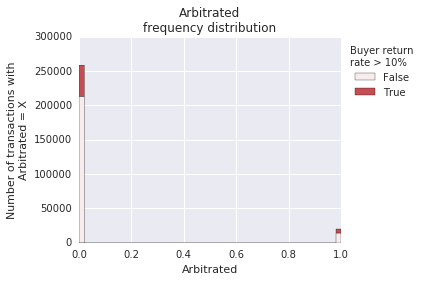

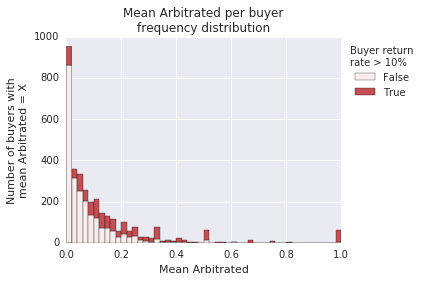

########################################
Feature: Autocheck_score
Timestamp: 2017-02-28T07:12:19GMT


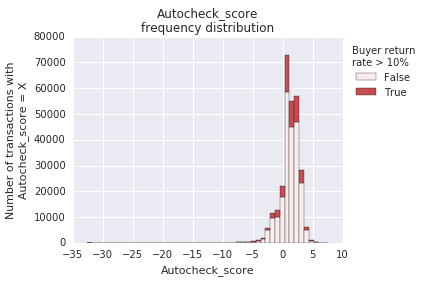

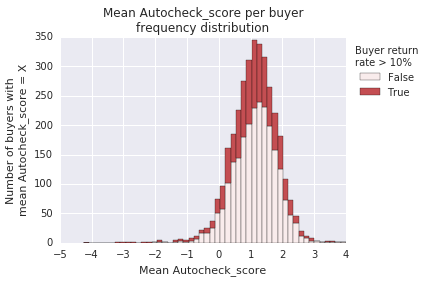

########################################
Feature: BuyerID_fracDSEligible1DivTransactions
Timestamp: 2017-02-28T07:12:21GMT


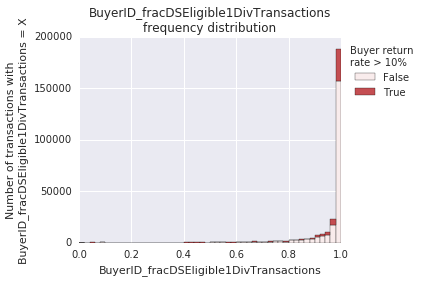

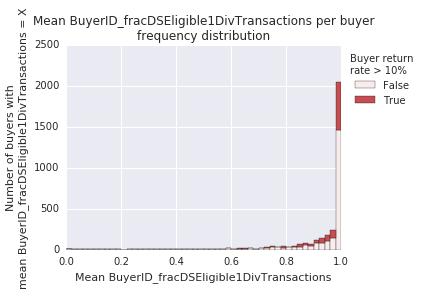

########################################
Feature: BuyerID_fracReturned1DivReturnedNotNull
Timestamp: 2017-02-28T07:12:23GMT


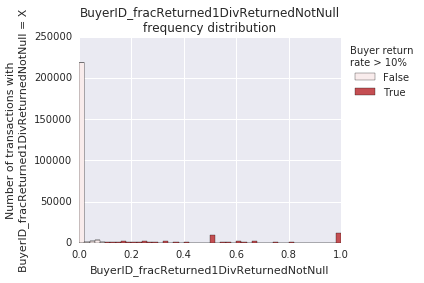

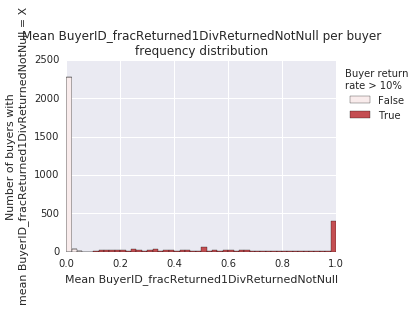

########################################
Feature: BuyerID_fracReturnedNotNullDivDSEligible1
Timestamp: 2017-02-28T07:12:25GMT


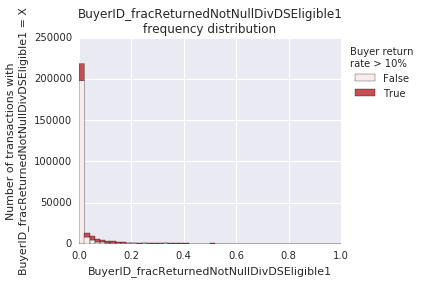

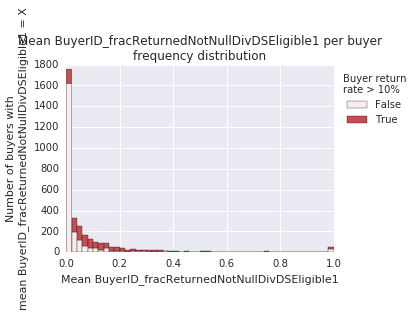

########################################
Feature: BuyerID_fracReturnedasm1DivTransactions
Timestamp: 2017-02-28T07:12:27GMT


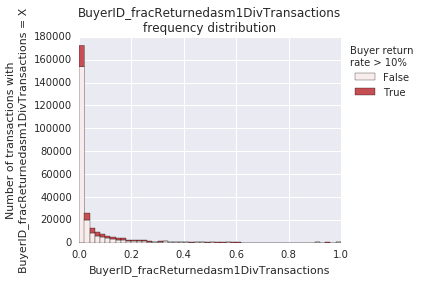

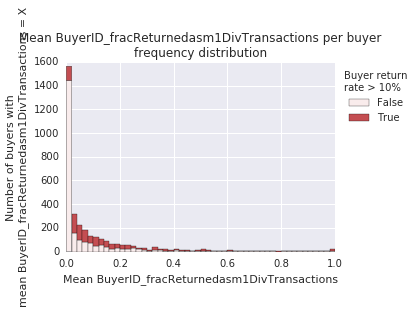

########################################
Feature: BuyerID_numDSEligible1
Timestamp: 2017-02-28T07:12:29GMT


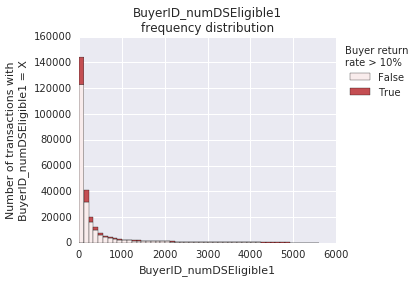

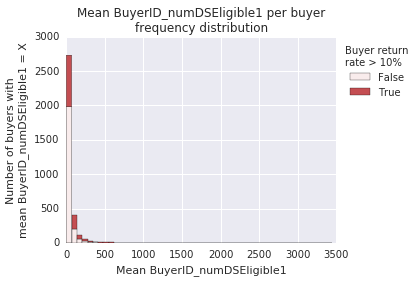

########################################
Feature: BuyerID_numReturned1
Timestamp: 2017-02-28T07:12:31GMT


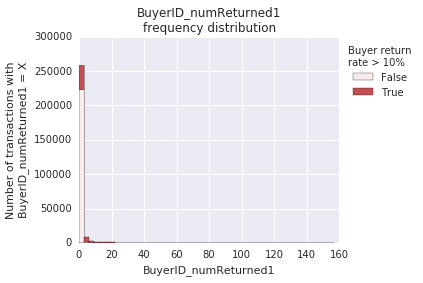

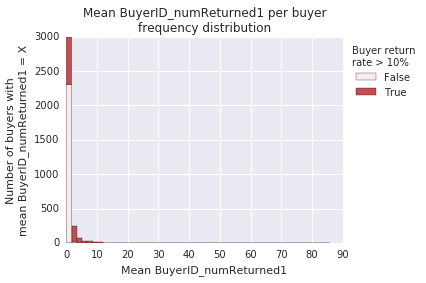

########################################
Feature: BuyerID_numReturnedNotNull
Timestamp: 2017-02-28T07:12:33GMT


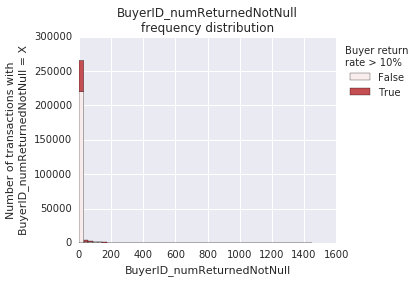

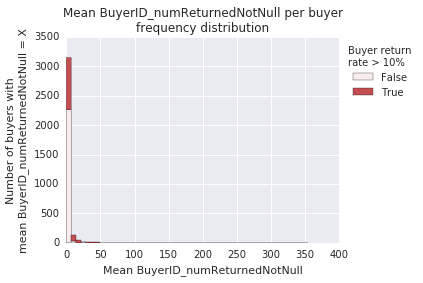

########################################
Feature: BuyerID_numReturnedasm1
Timestamp: 2017-02-28T07:12:35GMT


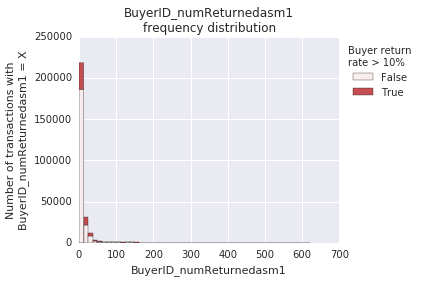

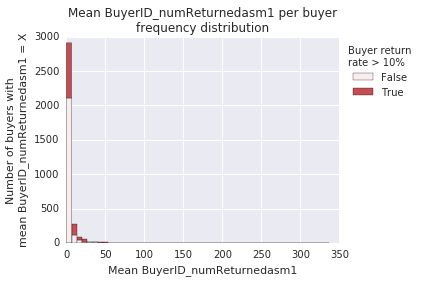

########################################
Feature: BuyerID_numTransactions
Timestamp: 2017-02-28T07:12:37GMT


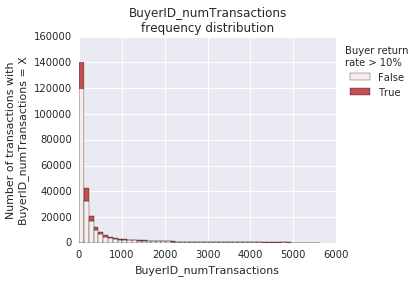

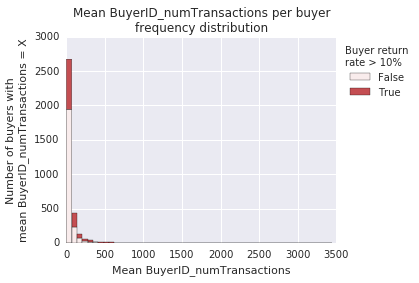

########################################
Feature: CarMake_fracDSEligible1DivTransactions
Timestamp: 2017-02-28T07:12:39GMT


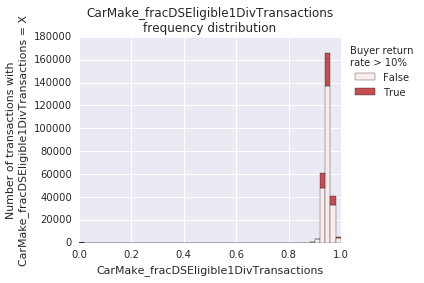

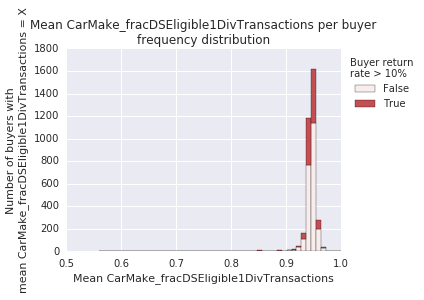

########################################
Feature: CarMake_fracReturned1DivReturnedNotNull
Timestamp: 2017-02-28T07:12:41GMT


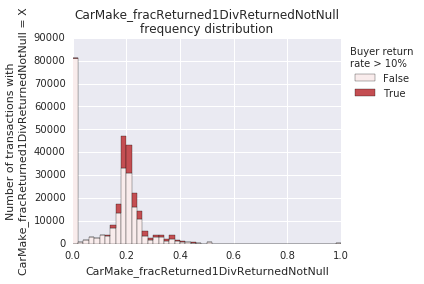

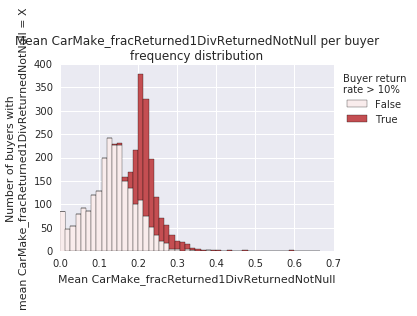

########################################
Feature: CarMake_fracReturnedNotNullDivDSEligible1
Timestamp: 2017-02-28T07:12:43GMT


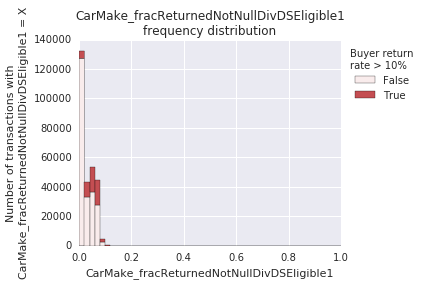

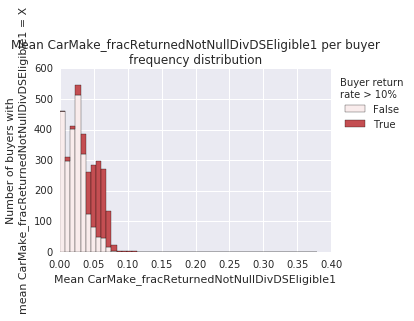

########################################
Feature: CarMake_fracReturnedasm1DivTransactions
Timestamp: 2017-02-28T07:12:45GMT


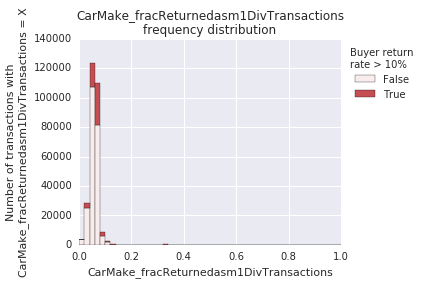

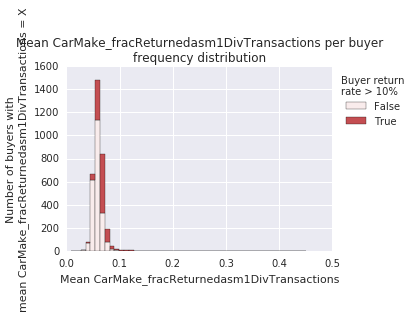

########################################
Feature: CarMake_numDSEligible1
Timestamp: 2017-02-28T07:12:47GMT


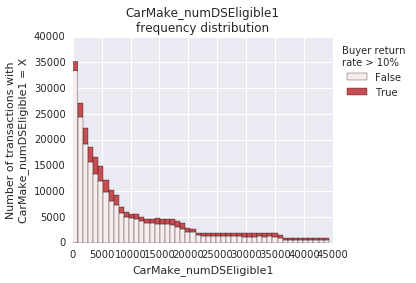

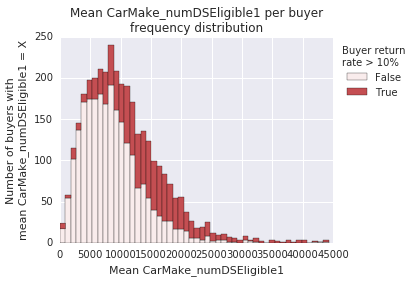

########################################
Feature: CarMake_numReturned1
Timestamp: 2017-02-28T07:12:49GMT


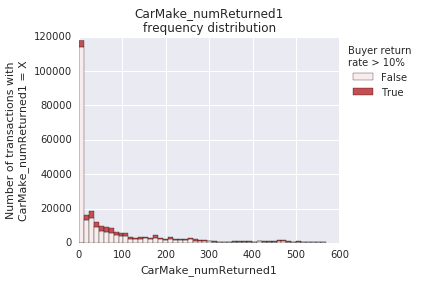

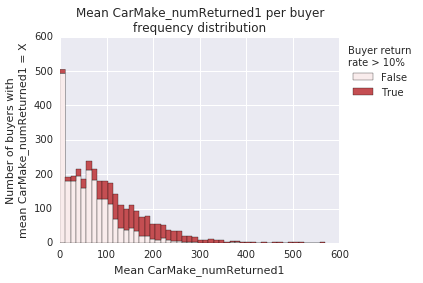

########################################
Feature: CarMake_numReturnedNotNull
Timestamp: 2017-02-28T07:12:51GMT


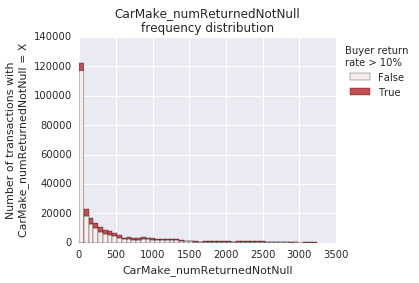

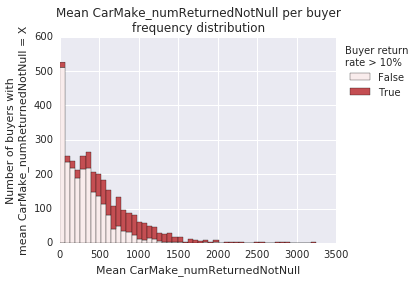

########################################
Feature: CarMake_numReturnedasm1
Timestamp: 2017-02-28T07:12:53GMT


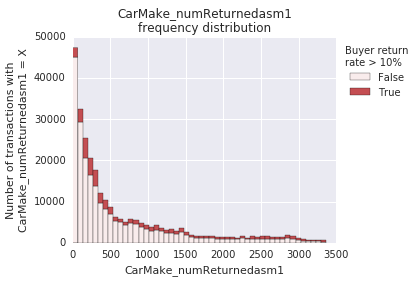

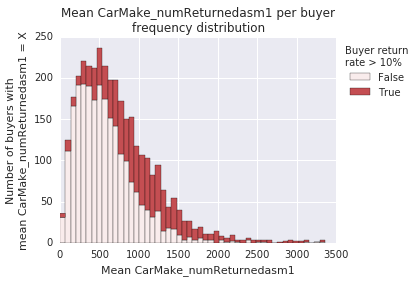

########################################
Feature: CarMake_numTransactions
Timestamp: 2017-02-28T07:12:54GMT


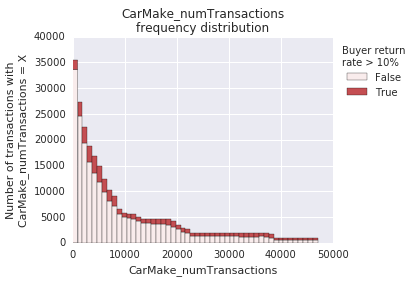

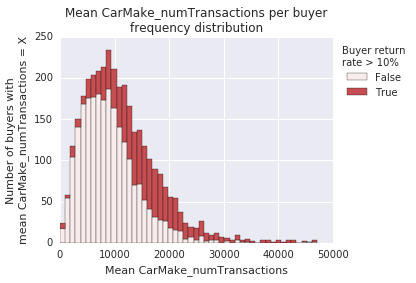

########################################
Feature: CarYear
Timestamp: 2017-02-28T07:12:56GMT


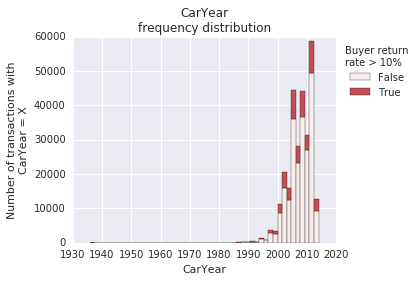

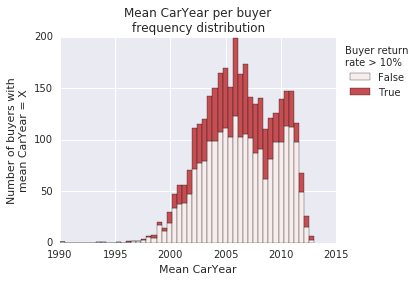

########################################
Feature: ConditionReport
Timestamp: 2017-02-28T07:12:58GMT


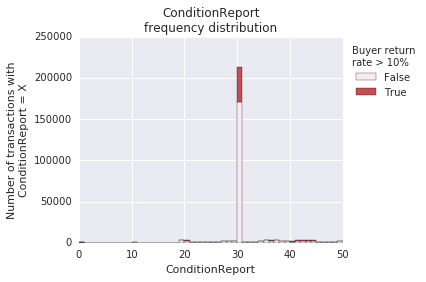

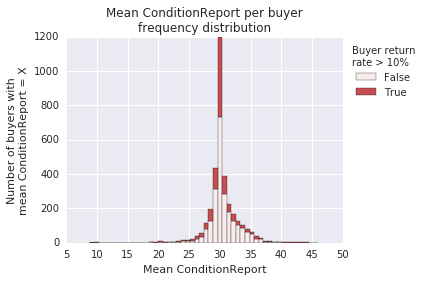

########################################
Feature: DSEligible
Timestamp: 2017-02-28T07:13:00GMT


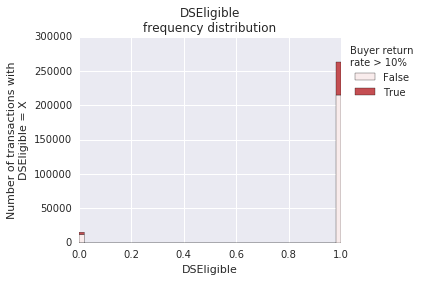

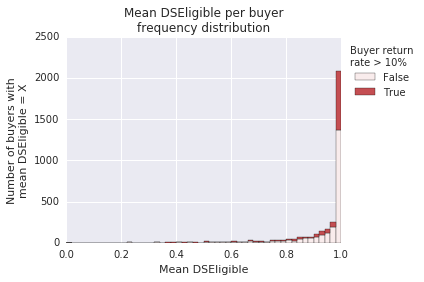

########################################
Feature: InLane
Timestamp: 2017-02-28T07:13:02GMT


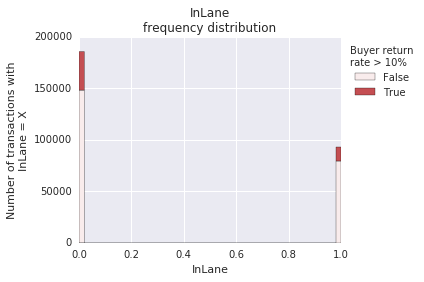

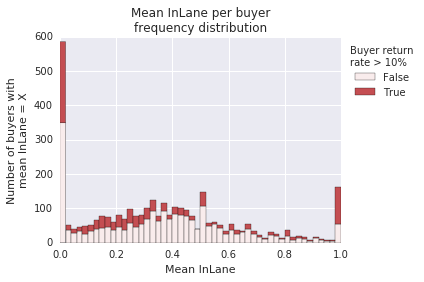

########################################
Feature: JDPowersCat_COMPACTCAR
Timestamp: 2017-02-28T07:13:04GMT


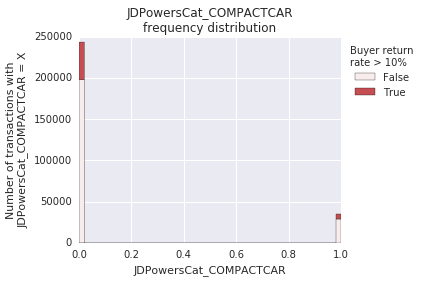

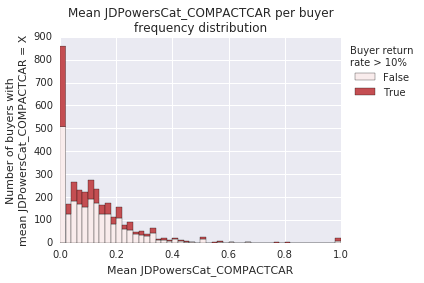

########################################
Feature: JDPowersCat_EXCLUDED
Timestamp: 2017-02-28T07:13:06GMT


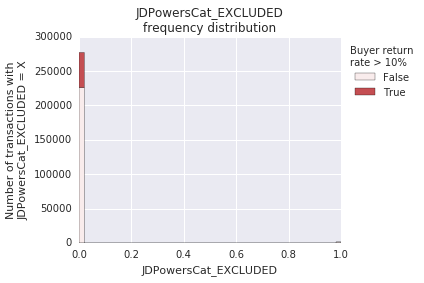

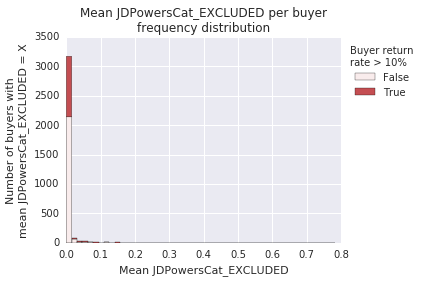

########################################
Feature: JDPowersCat_FULLSIZECAR
Timestamp: 2017-02-28T07:13:08GMT


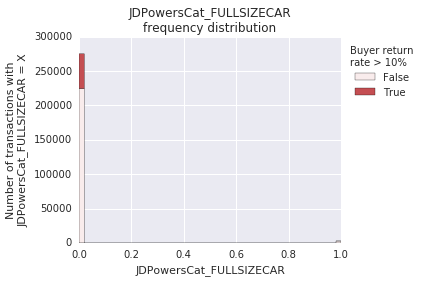

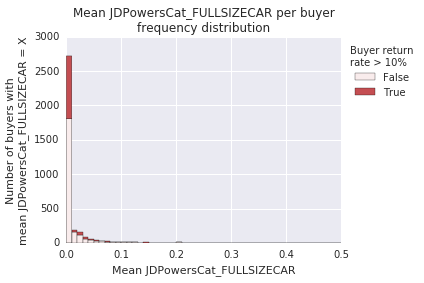

########################################
Feature: JDPowersCat_LUXURYCAR
Timestamp: 2017-02-28T07:13:10GMT


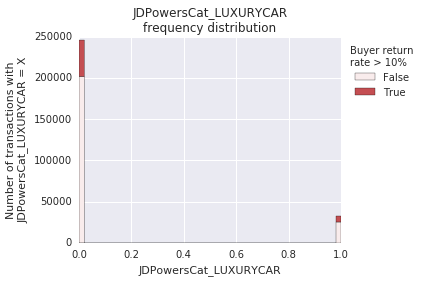

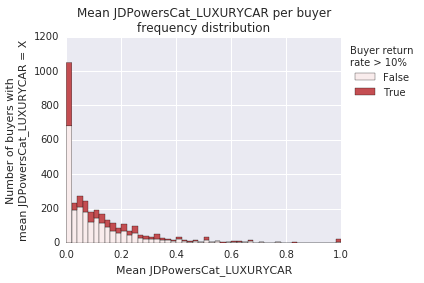

########################################
Feature: JDPowersCat_MIDSIZECAR
Timestamp: 2017-02-28T07:13:12GMT


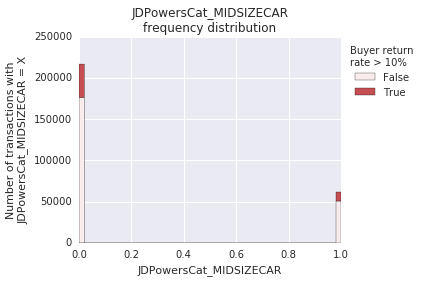

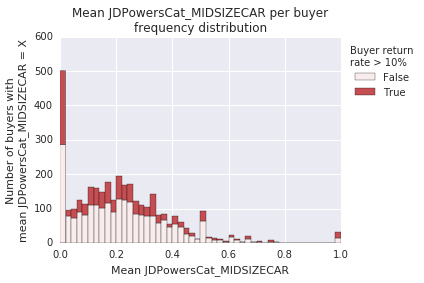

########################################
Feature: JDPowersCat_PICKUP
Timestamp: 2017-02-28T07:13:14GMT


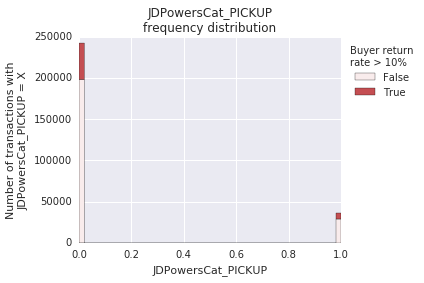

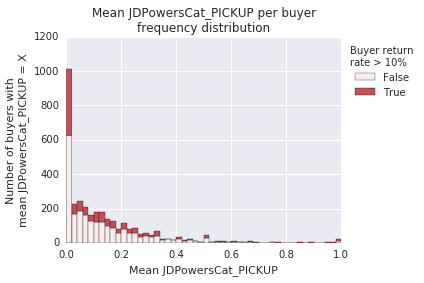

########################################
Feature: JDPowersCat_SPORTSCAR
Timestamp: 2017-02-28T07:13:16GMT


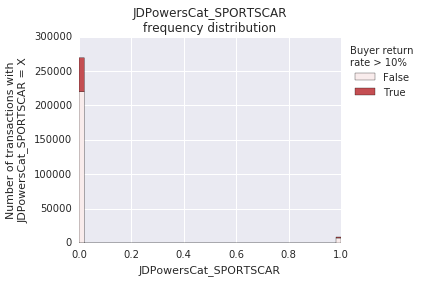

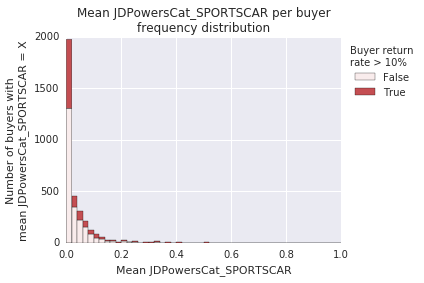

########################################
Feature: JDPowersCat_SUV
Timestamp: 2017-02-28T07:13:18GMT


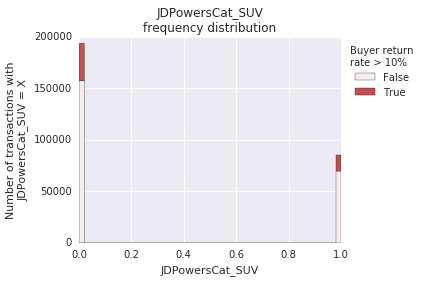

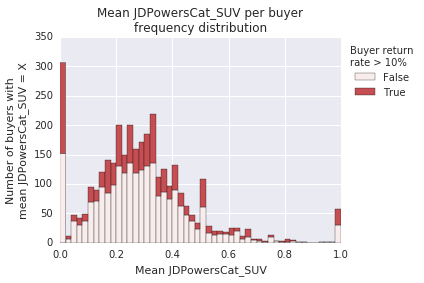

########################################
Feature: JDPowersCat_UNKNOWN
Timestamp: 2017-02-28T07:13:20GMT


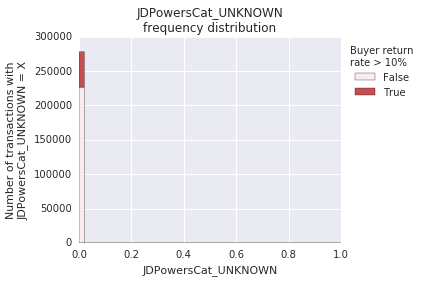

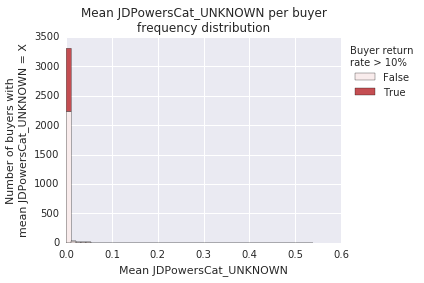

########################################
Feature: JDPowersCat_VAN
Timestamp: 2017-02-28T07:13:22GMT


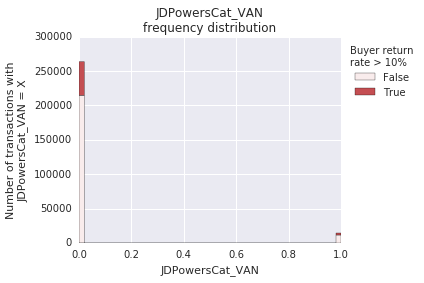

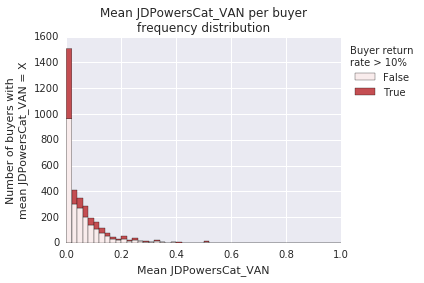

########################################
Feature: JDPowersCat_fracDSEligible1DivTransactions
Timestamp: 2017-02-28T07:13:24GMT


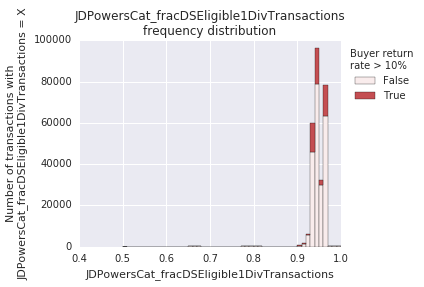

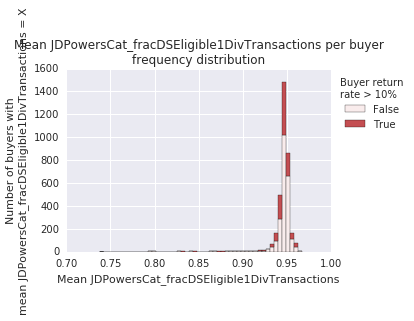

########################################
Feature: JDPowersCat_fracReturned1DivReturnedNotNull
Timestamp: 2017-02-28T07:13:26GMT


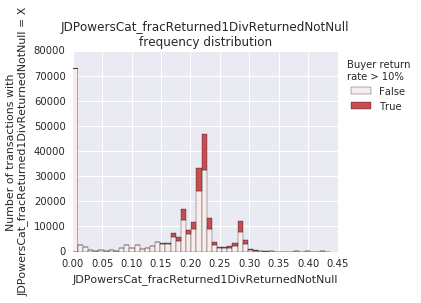

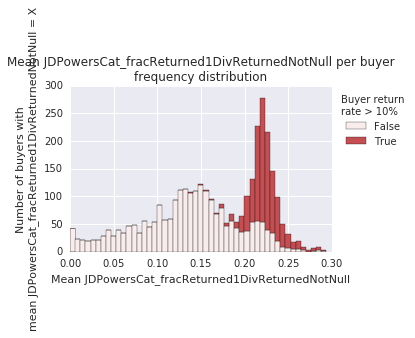

########################################
Feature: JDPowersCat_fracReturnedNotNullDivDSEligible1
Timestamp: 2017-02-28T07:13:28GMT


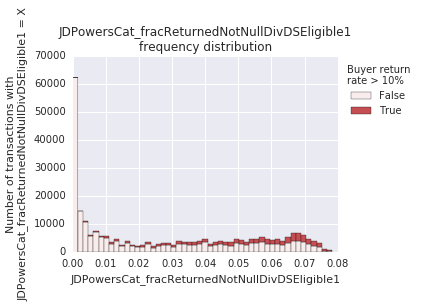

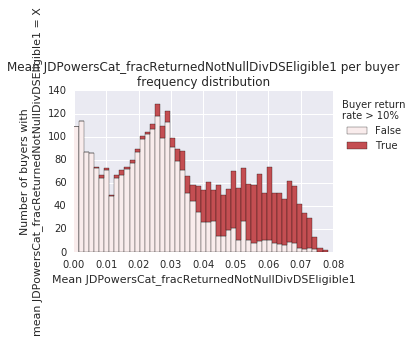

########################################
Feature: JDPowersCat_fracReturnedasm1DivTransactions
Timestamp: 2017-02-28T07:13:30GMT


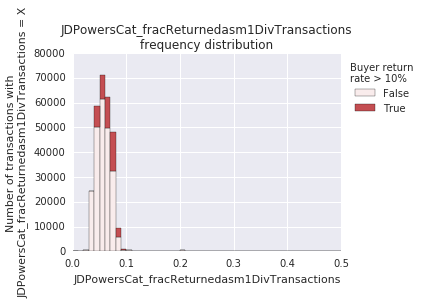

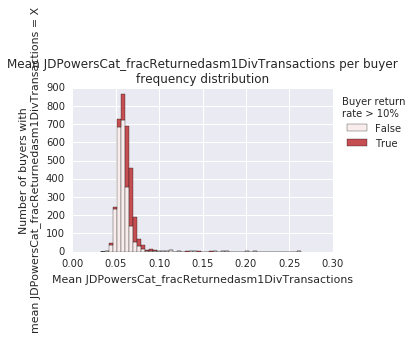

########################################
Feature: JDPowersCat_numDSEligible1
Timestamp: 2017-02-28T07:13:32GMT


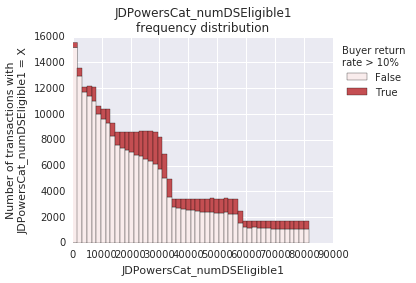

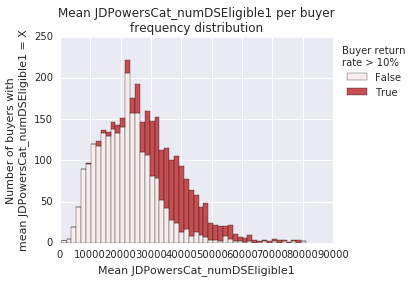

########################################
Feature: JDPowersCat_numReturned1
Timestamp: 2017-02-28T07:13:33GMT


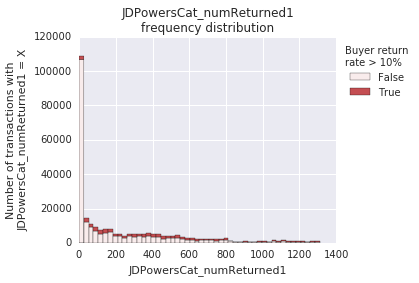

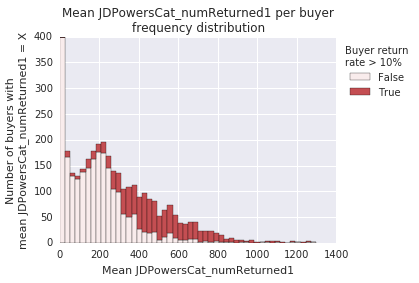

########################################
Feature: JDPowersCat_numReturnedNotNull
Timestamp: 2017-02-28T07:13:35GMT


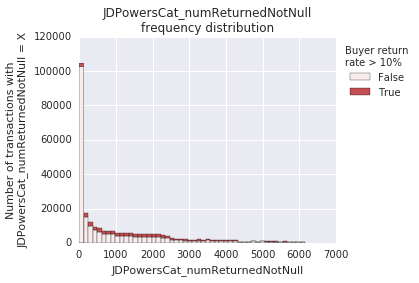

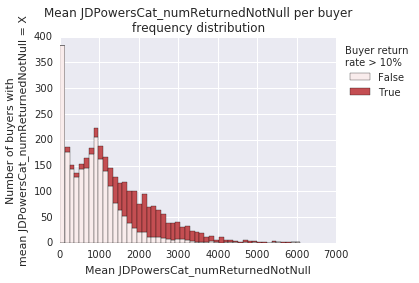

########################################
Feature: JDPowersCat_numReturnedasm1
Timestamp: 2017-02-28T07:13:37GMT


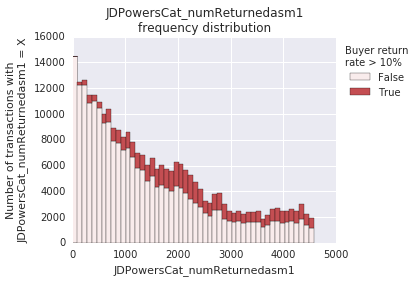

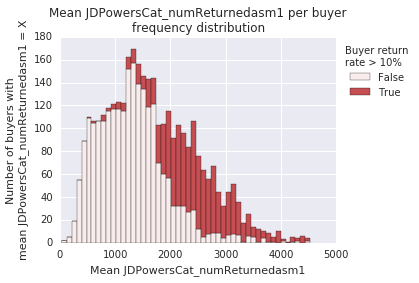

########################################
Feature: JDPowersCat_numTransactions
Timestamp: 2017-02-28T07:13:39GMT


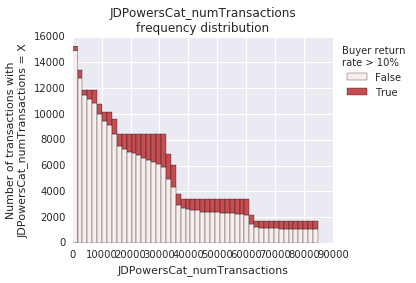

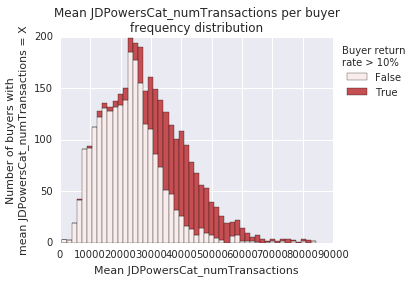

########################################
Feature: LIGHTG
Timestamp: 2017-02-28T07:13:41GMT


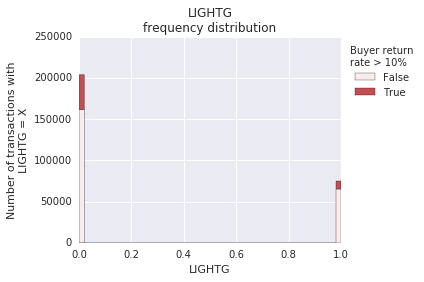

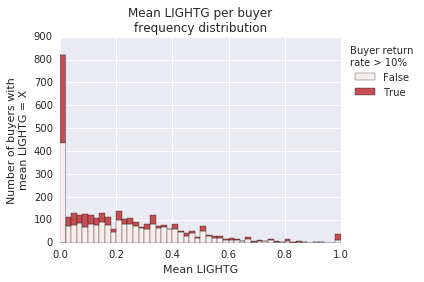

########################################
Feature: LIGHTR
Timestamp: 2017-02-28T07:13:43GMT


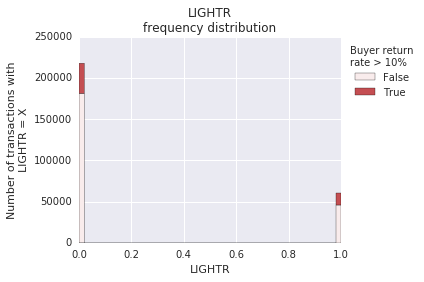

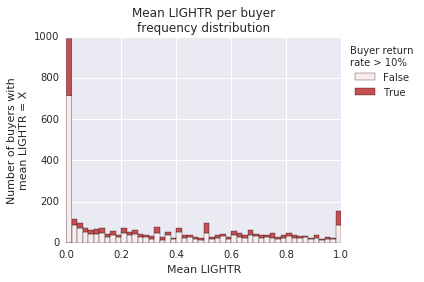

########################################
Feature: LIGHTY
Timestamp: 2017-02-28T07:13:45GMT


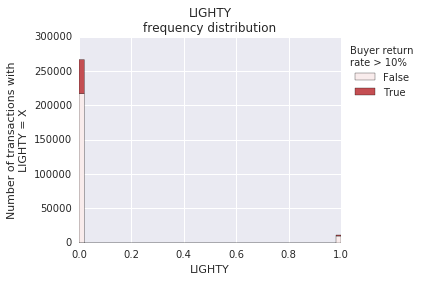

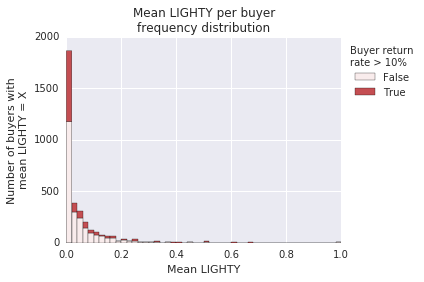

########################################
Feature: LIGHT_N0G1Y2R3
Timestamp: 2017-02-28T07:13:46GMT


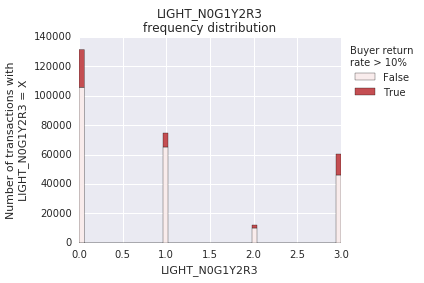

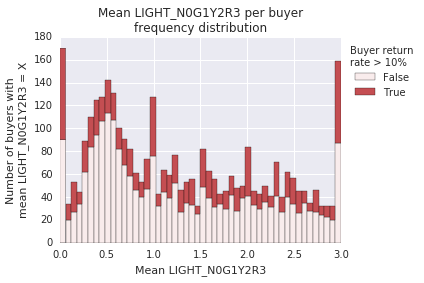

########################################
Feature: MMR
Timestamp: 2017-02-28T07:13:48GMT


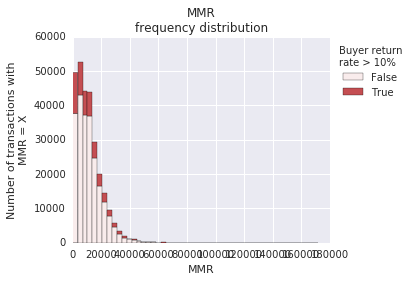

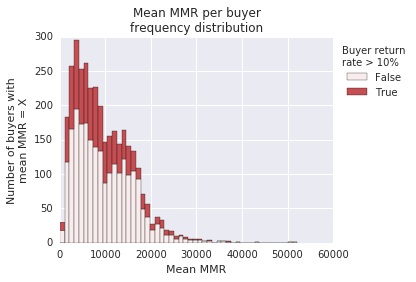

########################################
Feature: Mileage
Timestamp: 2017-02-28T07:13:50GMT


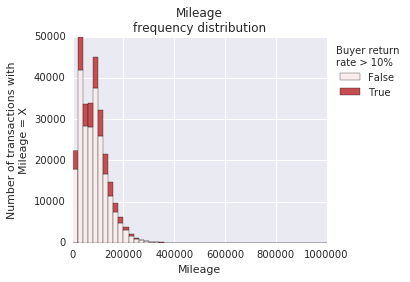

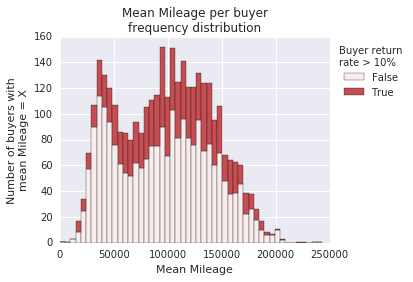

########################################
Feature: OVE
Timestamp: 2017-02-28T07:13:52GMT


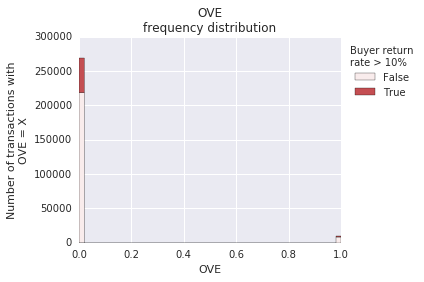

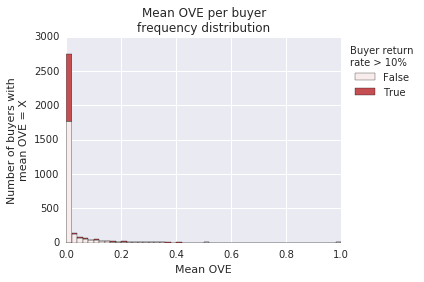

########################################
Feature: PSI
Timestamp: 2017-02-28T07:13:54GMT


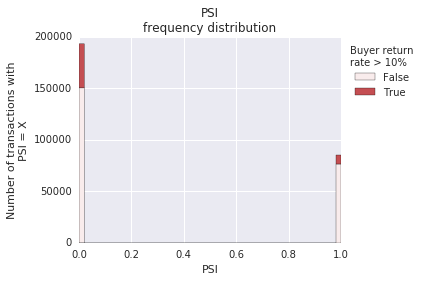

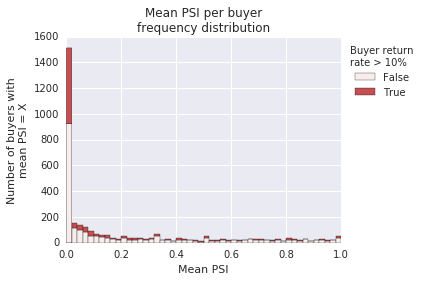

########################################
Feature: PSIEligible
Timestamp: 2017-02-28T07:13:55GMT


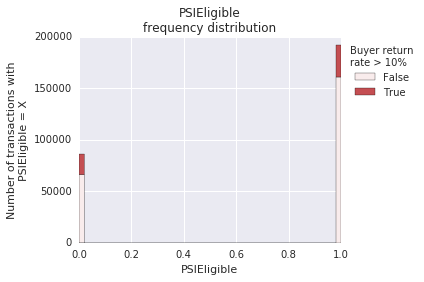

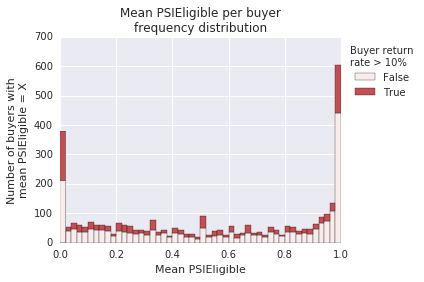

########################################
Feature: Returned
Timestamp: 2017-02-28T07:13:57GMT


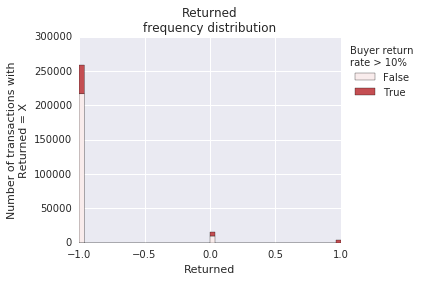

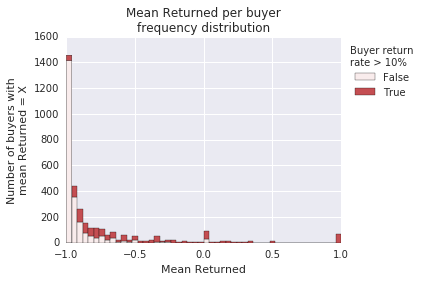

########################################
Feature: Returned_asm
Timestamp: 2017-02-28T07:13:59GMT


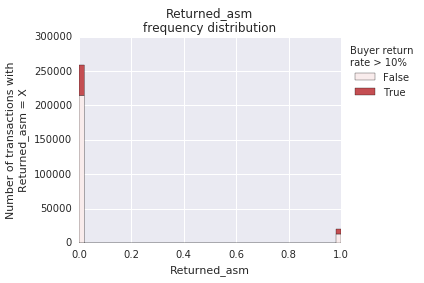

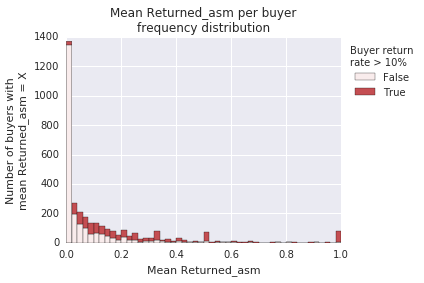

########################################
Feature: SaleDate_day
Timestamp: 2017-02-28T07:14:01GMT


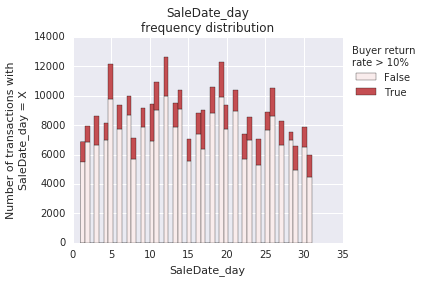

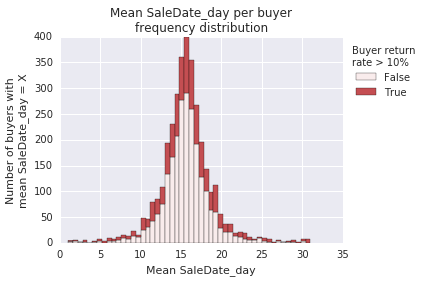

########################################
Feature: SaleDate_decyear
Timestamp: 2017-02-28T07:14:03GMT


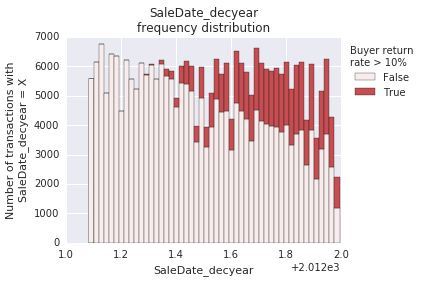

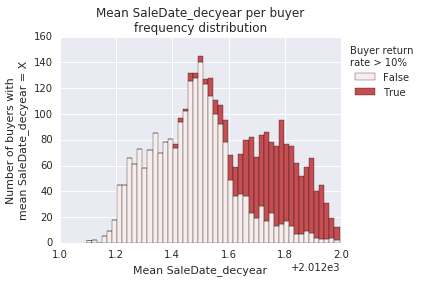

########################################
Feature: SaleDate_dow
Timestamp: 2017-02-28T07:14:04GMT


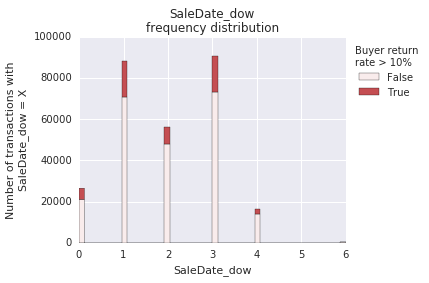

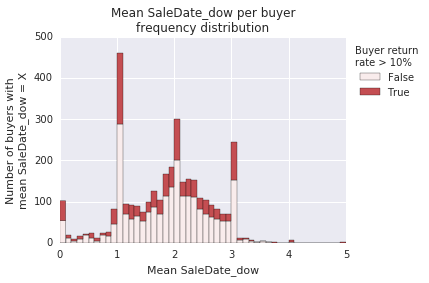

########################################
Feature: SaleDate_doy
Timestamp: 2017-02-28T07:14:06GMT


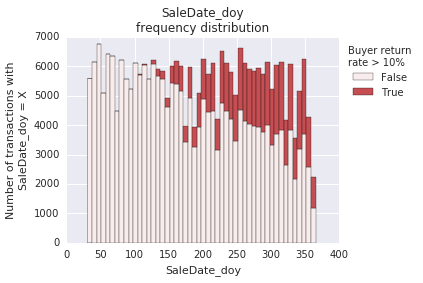

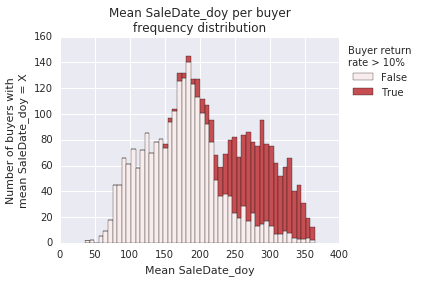

########################################
Feature: SalePrice
Timestamp: 2017-02-28T07:14:08GMT


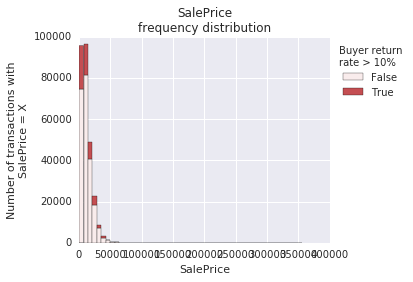

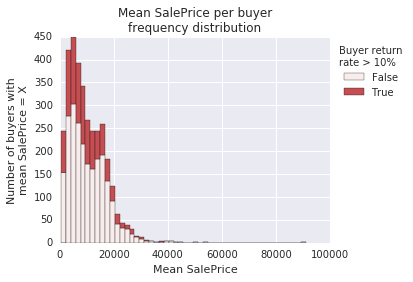

########################################
Feature: Salvage
Timestamp: 2017-02-28T07:14:10GMT


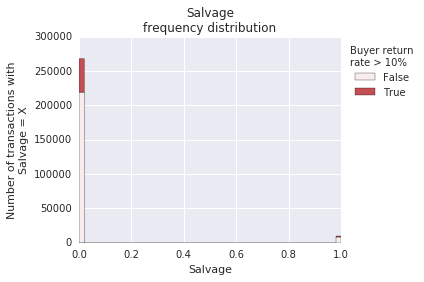

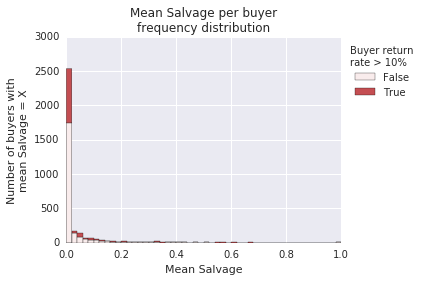

########################################
Feature: SellerID_fracDSEligible1DivTransactions
Timestamp: 2017-02-28T07:14:12GMT


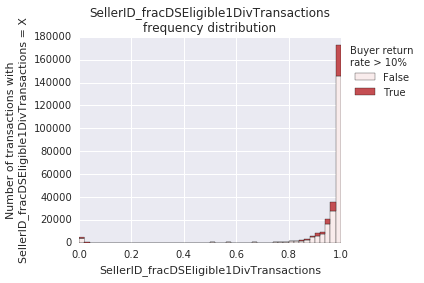

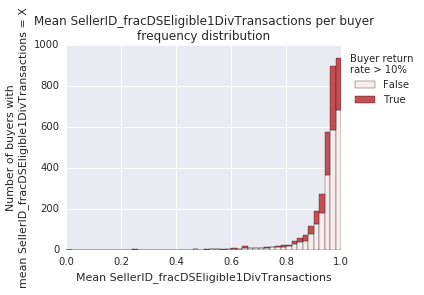

########################################
Feature: SellerID_fracReturned1DivReturnedNotNull
Timestamp: 2017-02-28T07:14:14GMT


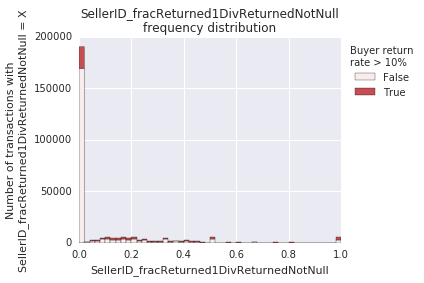

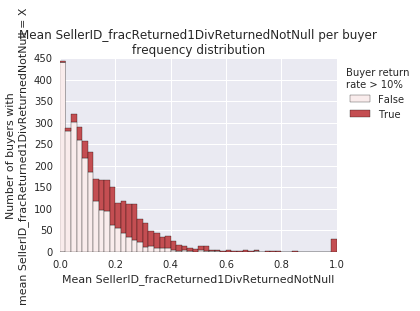

########################################
Feature: SellerID_fracReturnedNotNullDivDSEligible1
Timestamp: 2017-02-28T07:14:15GMT


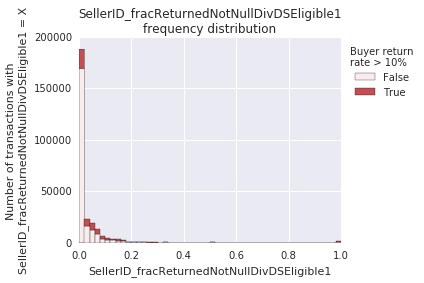

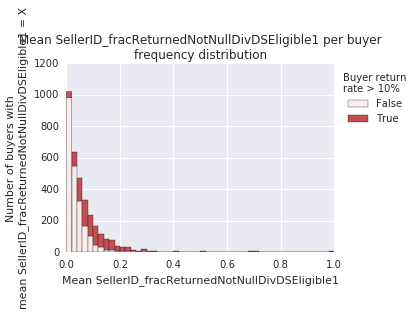

########################################
Feature: SellerID_fracReturnedasm1DivTransactions
Timestamp: 2017-02-28T07:14:17GMT


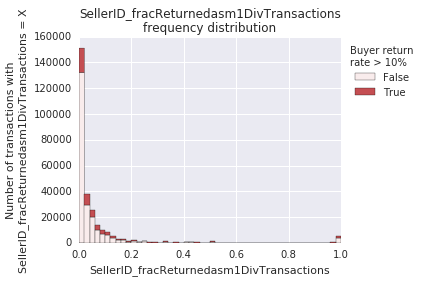

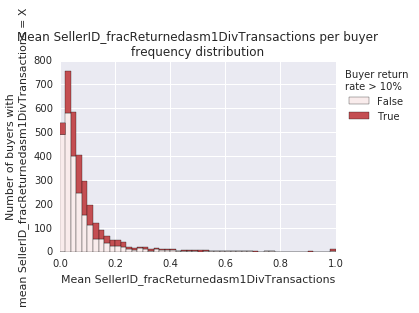

########################################
Feature: SellerID_numDSEligible1
Timestamp: 2017-02-28T07:14:19GMT


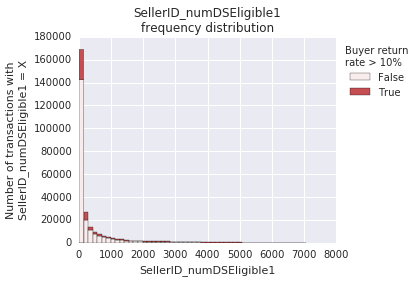

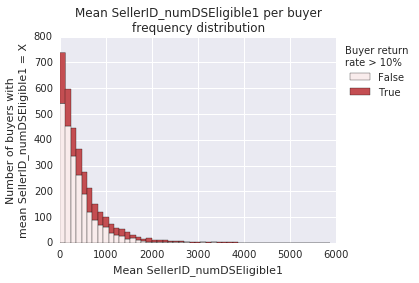

########################################
Feature: SellerID_numReturned1
Timestamp: 2017-02-28T07:14:21GMT


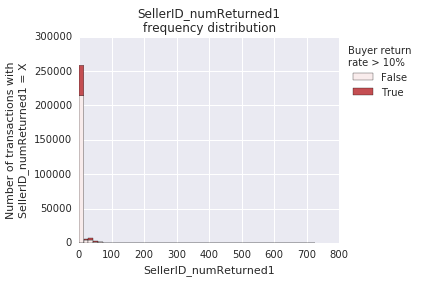

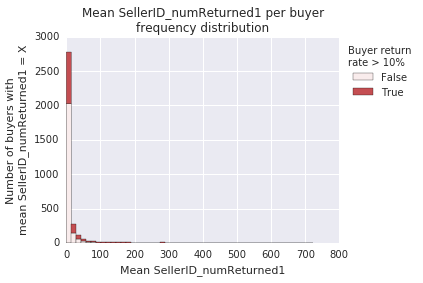

########################################
Feature: SellerID_numReturnedNotNull
Timestamp: 2017-02-28T07:14:23GMT


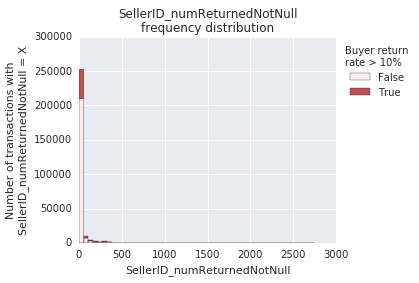

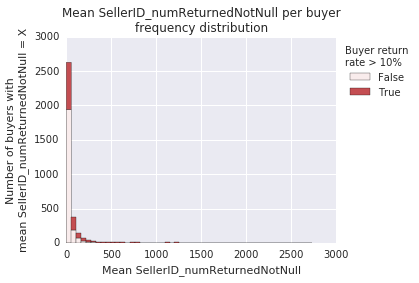

########################################
Feature: SellerID_numReturnedasm1
Timestamp: 2017-02-28T07:14:25GMT


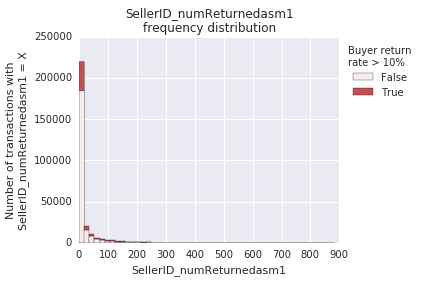

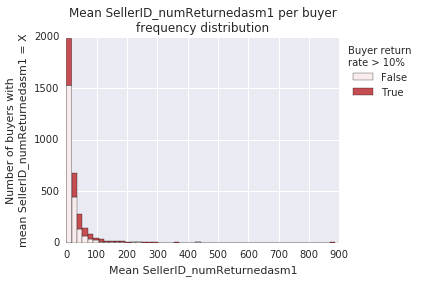

########################################
Feature: SellerID_numTransactions
Timestamp: 2017-02-28T07:14:26GMT


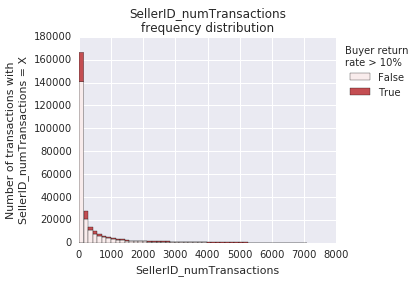

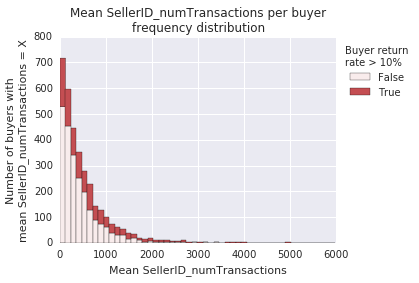

########################################
Feature: SellingLocation_fracDSEligible1DivTransactions
Timestamp: 2017-02-28T07:14:28GMT


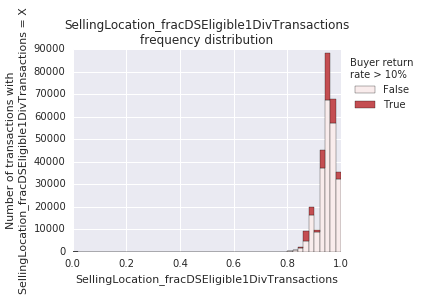

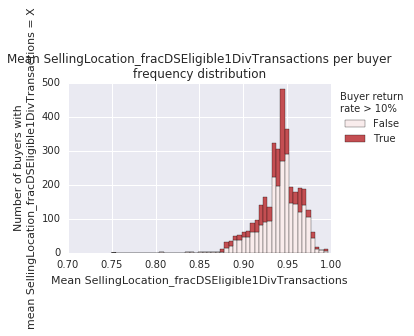

########################################
Feature: SellingLocation_fracReturned1DivReturnedNotNull
Timestamp: 2017-02-28T07:14:30GMT


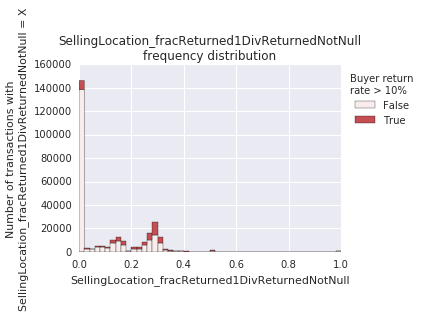

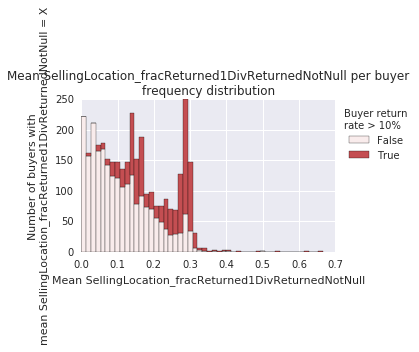

########################################
Feature: SellingLocation_fracReturnedNotNullDivDSEligible1
Timestamp: 2017-02-28T07:14:32GMT


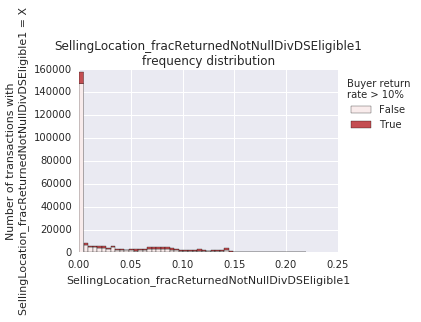

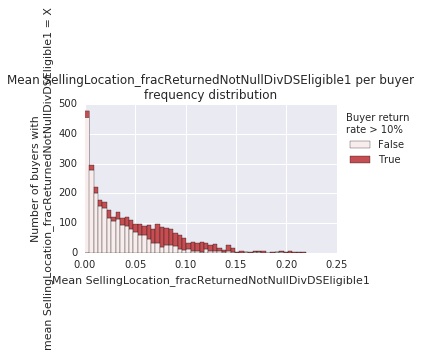

########################################
Feature: SellingLocation_fracReturnedasm1DivTransactions
Timestamp: 2017-02-28T07:14:34GMT


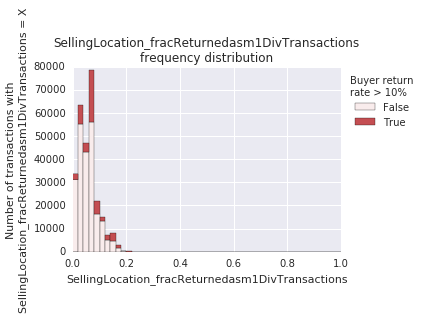

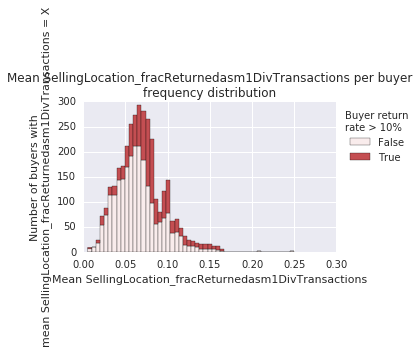

########################################
Feature: SellingLocation_lat
Timestamp: 2017-02-28T07:14:36GMT


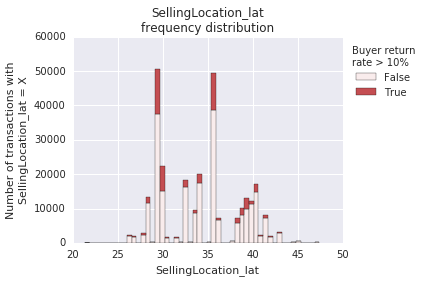

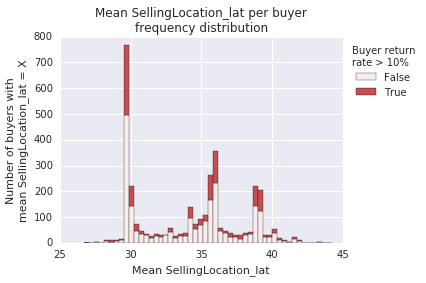

########################################
Feature: SellingLocation_lon
Timestamp: 2017-02-28T07:14:38GMT


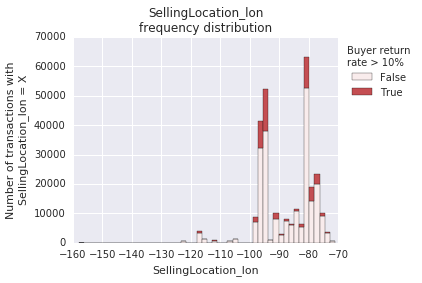

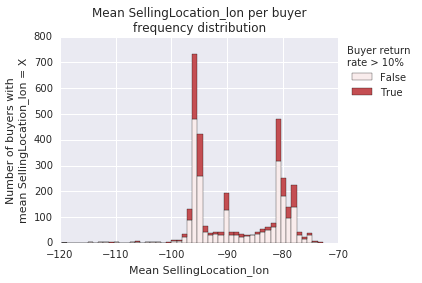

########################################
Feature: SellingLocation_numDSEligible1
Timestamp: 2017-02-28T07:14:40GMT


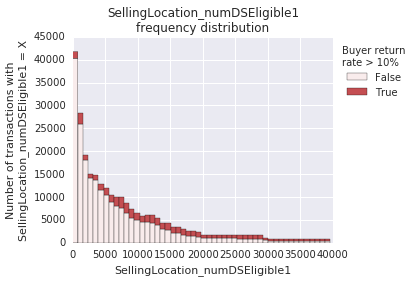

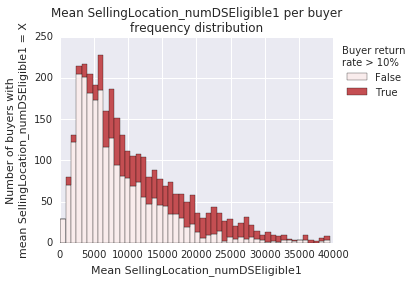

########################################
Feature: SellingLocation_numReturned1
Timestamp: 2017-02-28T07:14:42GMT


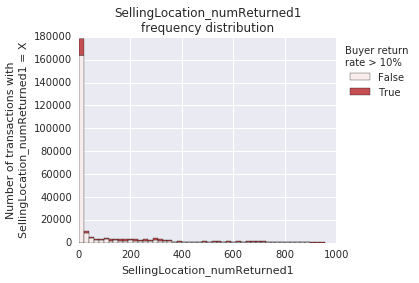

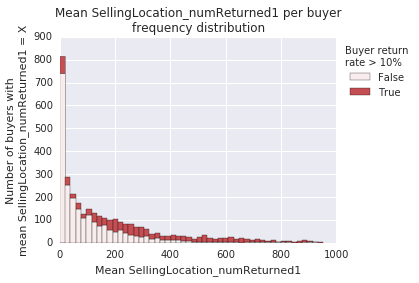

########################################
Feature: SellingLocation_numReturnedNotNull
Timestamp: 2017-02-28T07:14:43GMT


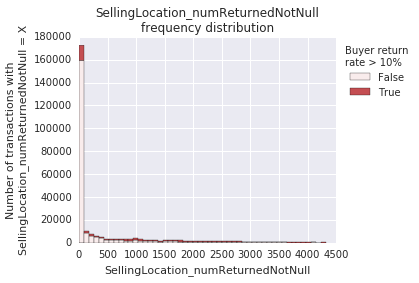

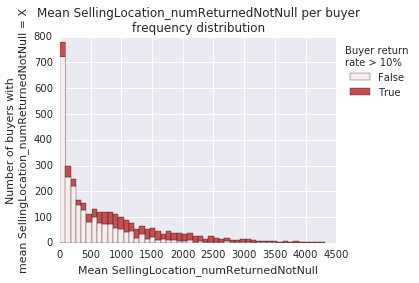

########################################
Feature: SellingLocation_numReturnedasm1
Timestamp: 2017-02-28T07:14:45GMT


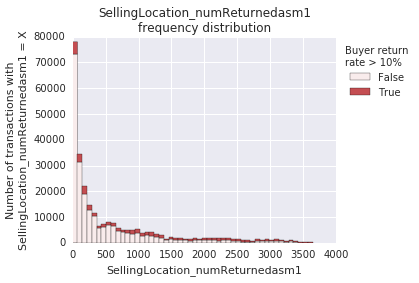

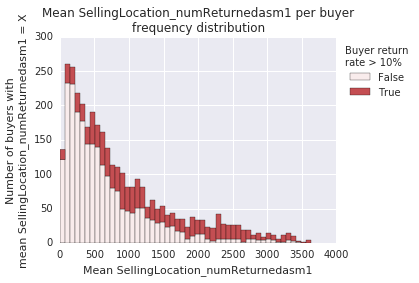

########################################
Feature: SellingLocation_numTransactions
Timestamp: 2017-02-28T07:14:47GMT


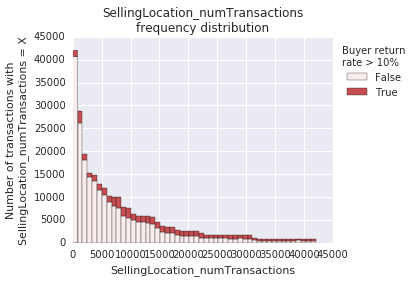

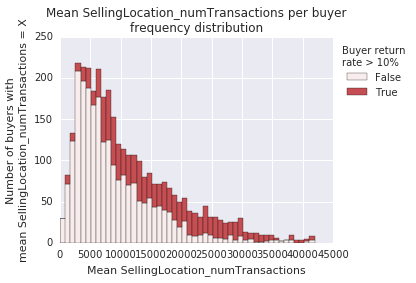

########################################
Feature: Simulcast
Timestamp: 2017-02-28T07:14:49GMT


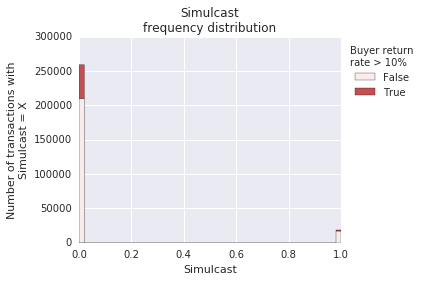

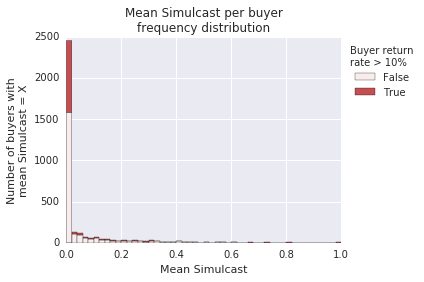

########################################
Feature: VIN_fracDSEligible1DivTransactions
Timestamp: 2017-02-28T07:14:51GMT


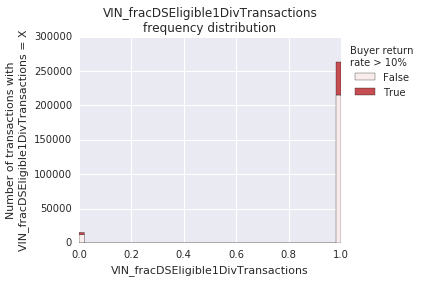

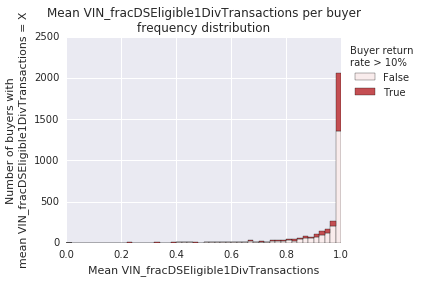

########################################
Feature: VIN_fracReturned1DivReturnedNotNull
Timestamp: 2017-02-28T07:14:53GMT


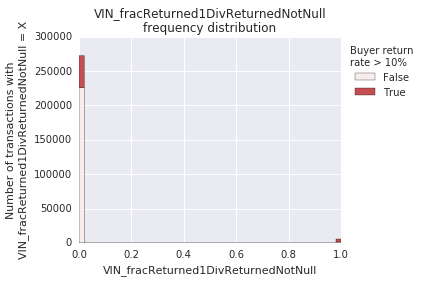

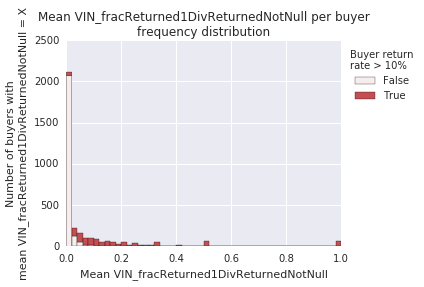

########################################
Feature: VIN_fracReturnedNotNullDivDSEligible1
Timestamp: 2017-02-28T07:14:55GMT


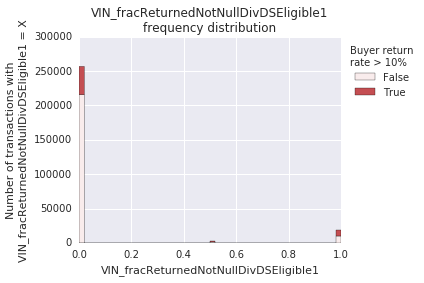

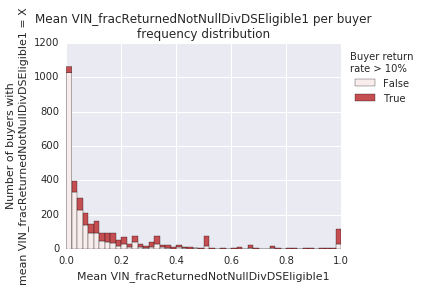

########################################
Feature: VIN_fracReturnedasm1DivTransactions
Timestamp: 2017-02-28T07:14:56GMT


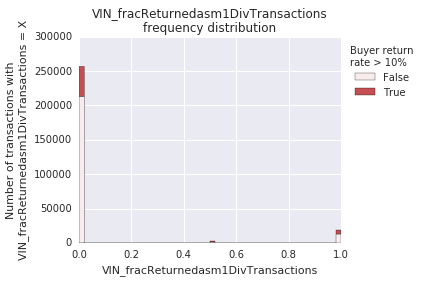

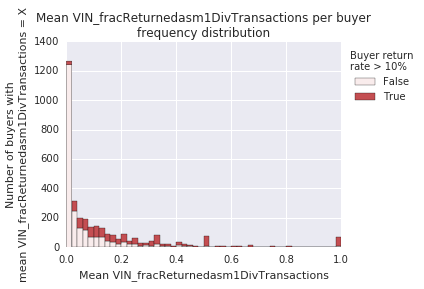

########################################
Feature: VIN_numDSEligible1
Timestamp: 2017-02-28T07:14:58GMT


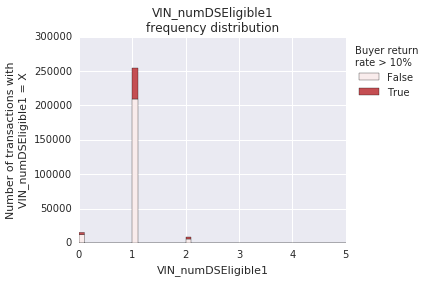

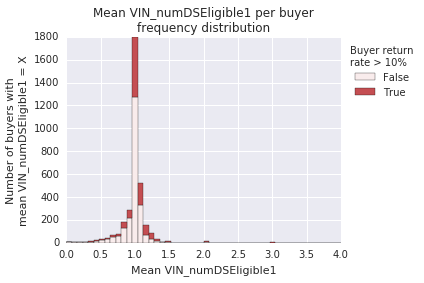

########################################
Feature: VIN_numReturned1
Timestamp: 2017-02-28T07:15:00GMT


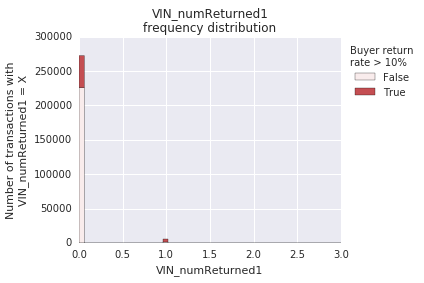

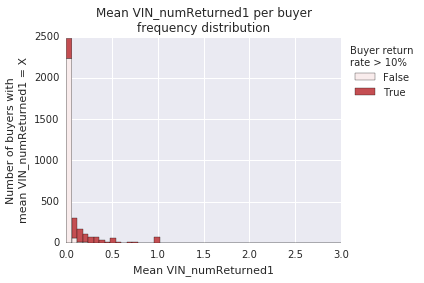

########################################
Feature: VIN_numReturnedNotNull
Timestamp: 2017-02-28T07:15:02GMT


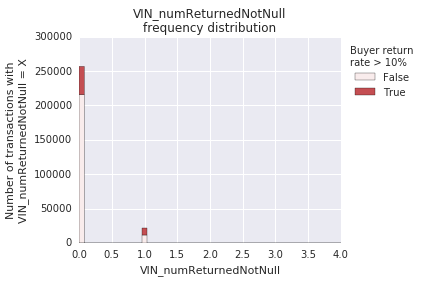

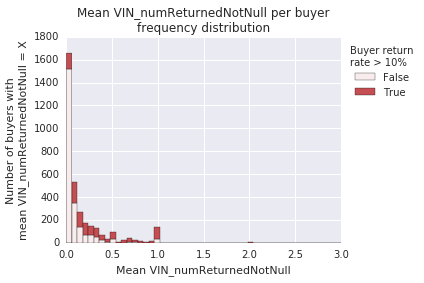

########################################
Feature: VIN_numReturnedasm1
Timestamp: 2017-02-28T07:15:04GMT


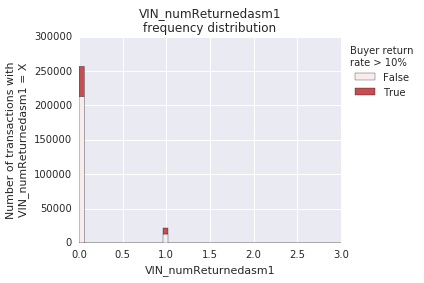

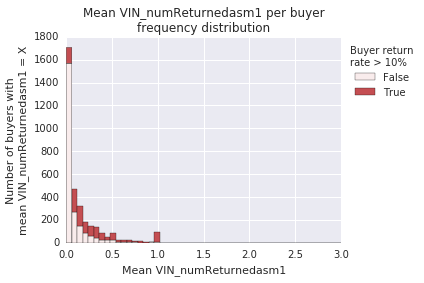

########################################
Feature: VIN_numTransactions
Timestamp: 2017-02-28T07:15:06GMT


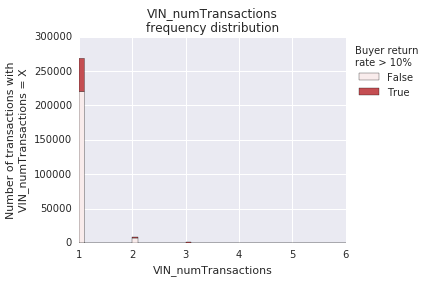

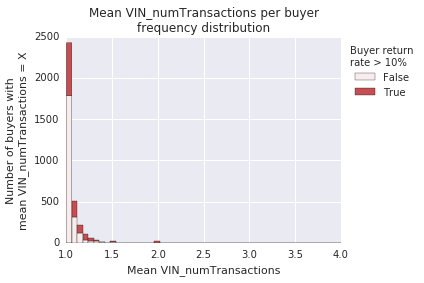

################################################################################
Plot traces (timeseries) for fractional quantities vs fraction of completed transactions.
########################################
Category column:    BuyerID
Transaction column: BuyerID_numTransactions
Fraction column:    BuyerID_fracDSEligible1DivTransactions
Timestamp: 2017-02-28T07:15:07GMT


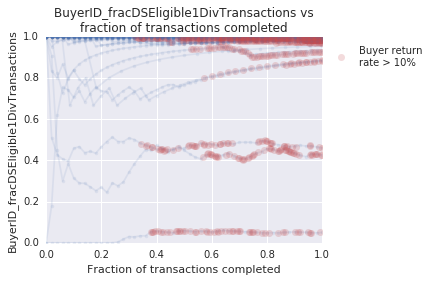

########################################
Category column:    BuyerID
Transaction column: BuyerID_numTransactions
Fraction column:    BuyerID_fracReturnedNotNullDivDSEligible1
Timestamp: 2017-02-28T07:15:31GMT


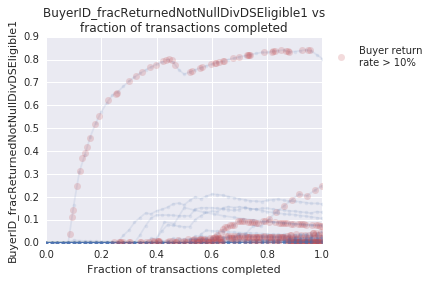

########################################
Category column:    BuyerID
Transaction column: BuyerID_numTransactions
Fraction column:    BuyerID_fracReturned1DivReturnedNotNull
Timestamp: 2017-02-28T07:15:55GMT


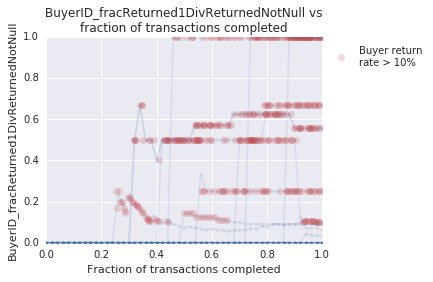

########################################
Category column:    BuyerID
Transaction column: BuyerID_numTransactions
Fraction column:    BuyerID_fracReturnedasm1DivTransactions
Timestamp: 2017-02-28T07:16:19GMT


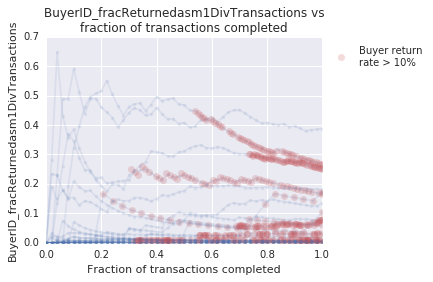

########################################
Category column:    SellerID
Transaction column: SellerID_numTransactions
Fraction column:    SellerID_fracDSEligible1DivTransactions
Timestamp: 2017-02-28T07:16:43GMT


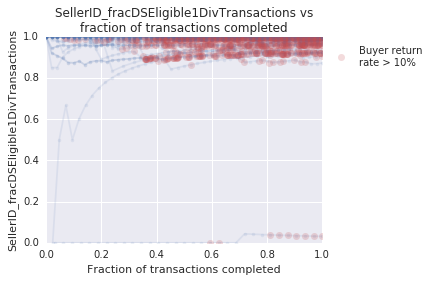

########################################
Category column:    SellerID
Transaction column: SellerID_numTransactions
Fraction column:    SellerID_fracReturnedNotNullDivDSEligible1
Timestamp: 2017-02-28T07:17:06GMT


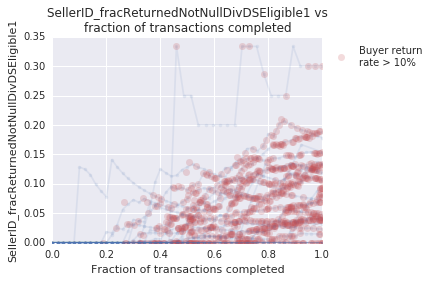

########################################
Category column:    SellerID
Transaction column: SellerID_numTransactions
Fraction column:    SellerID_fracReturned1DivReturnedNotNull
Timestamp: 2017-02-28T07:17:28GMT


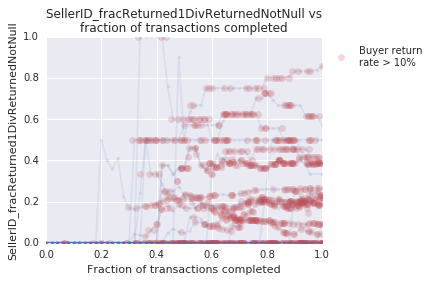

########################################
Category column:    SellerID
Transaction column: SellerID_numTransactions
Fraction column:    SellerID_fracReturnedasm1DivTransactions
Timestamp: 2017-02-28T07:17:51GMT


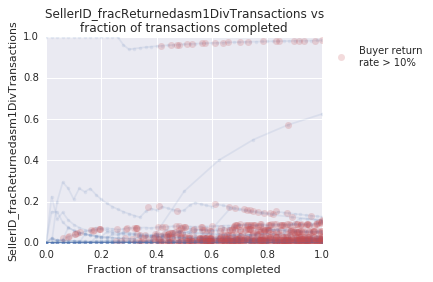

########################################
Category column:    VIN
Transaction column: VIN_numTransactions
Fraction column:    VIN_fracDSEligible1DivTransactions
Timestamp: 2017-02-28T07:18:13GMT


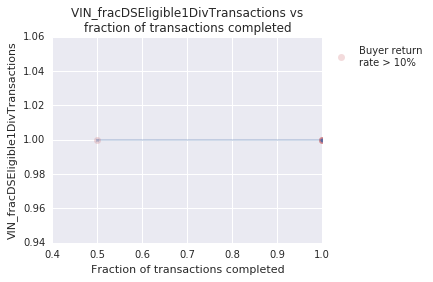

########################################
Category column:    VIN
Transaction column: VIN_numTransactions
Fraction column:    VIN_fracReturnedNotNullDivDSEligible1
Timestamp: 2017-02-28T07:18:36GMT


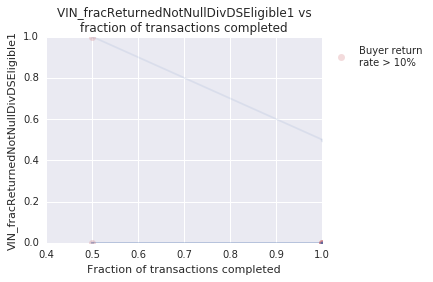

########################################
Category column:    VIN
Transaction column: VIN_numTransactions
Fraction column:    VIN_fracReturned1DivReturnedNotNull
Timestamp: 2017-02-28T07:19:00GMT


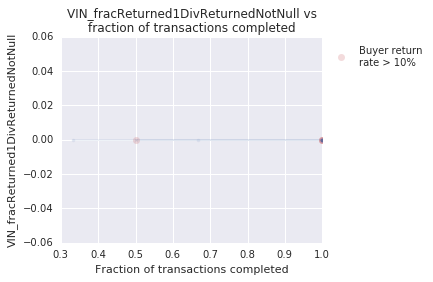

########################################
Category column:    VIN
Transaction column: VIN_numTransactions
Fraction column:    VIN_fracReturnedasm1DivTransactions
Timestamp: 2017-02-28T07:19:23GMT


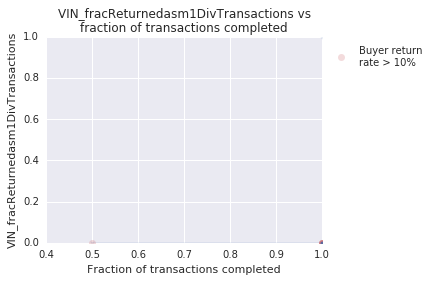

########################################
Category column:    SellingLocation
Transaction column: SellingLocation_numTransactions
Fraction column:    SellingLocation_fracDSEligible1DivTransactions
Timestamp: 2017-02-28T07:19:46GMT


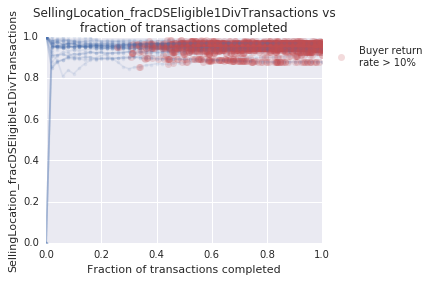

########################################
Category column:    SellingLocation
Transaction column: SellingLocation_numTransactions
Fraction column:    SellingLocation_fracReturnedNotNullDivDSEligible1
Timestamp: 2017-02-28T07:20:08GMT


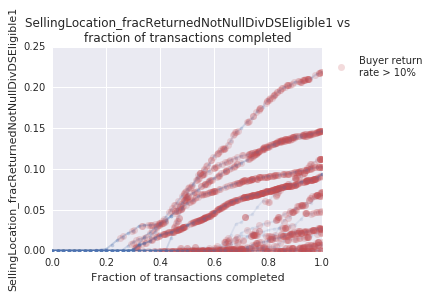

########################################
Category column:    SellingLocation
Transaction column: SellingLocation_numTransactions
Fraction column:    SellingLocation_fracReturned1DivReturnedNotNull
Timestamp: 2017-02-28T07:20:29GMT


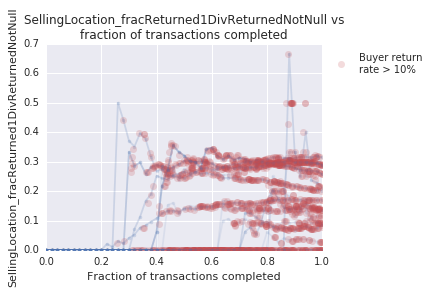

########################################
Category column:    SellingLocation
Transaction column: SellingLocation_numTransactions
Fraction column:    SellingLocation_fracReturnedasm1DivTransactions
Timestamp: 2017-02-28T07:20:51GMT


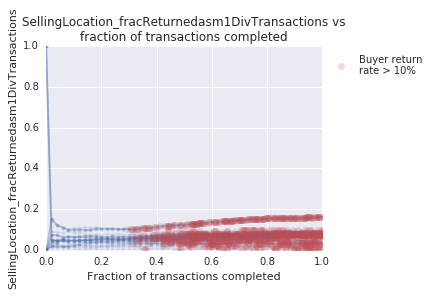

########################################
Category column:    CarMake
Transaction column: CarMake_numTransactions
Fraction column:    CarMake_fracDSEligible1DivTransactions
Timestamp: 2017-02-28T07:21:12GMT


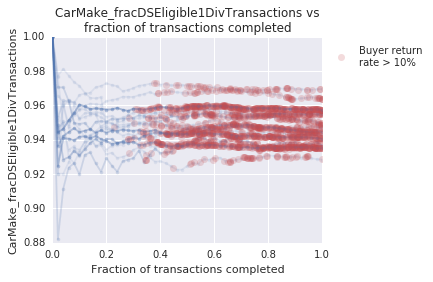

########################################
Category column:    CarMake
Transaction column: CarMake_numTransactions
Fraction column:    CarMake_fracReturnedNotNullDivDSEligible1
Timestamp: 2017-02-28T07:21:34GMT


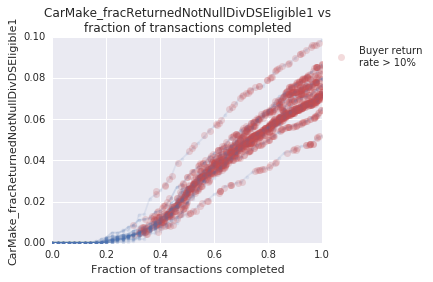

########################################
Category column:    CarMake
Transaction column: CarMake_numTransactions
Fraction column:    CarMake_fracReturned1DivReturnedNotNull
Timestamp: 2017-02-28T07:21:55GMT


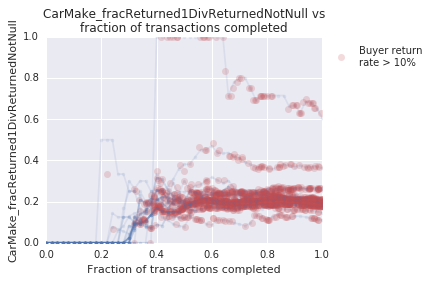

########################################
Category column:    CarMake
Transaction column: CarMake_numTransactions
Fraction column:    CarMake_fracReturnedasm1DivTransactions
Timestamp: 2017-02-28T07:22:16GMT


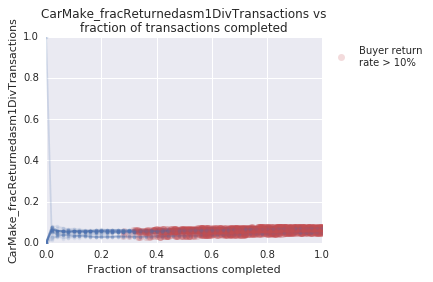

########################################
Category column:    JDPowersCat
Transaction column: JDPowersCat_numTransactions
Fraction column:    JDPowersCat_fracDSEligible1DivTransactions
Timestamp: 2017-02-28T07:22:38GMT


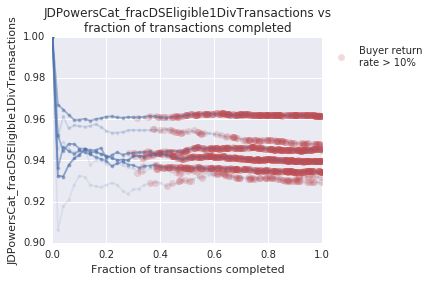

########################################
Category column:    JDPowersCat
Transaction column: JDPowersCat_numTransactions
Fraction column:    JDPowersCat_fracReturnedNotNullDivDSEligible1
Timestamp: 2017-02-28T07:23:00GMT


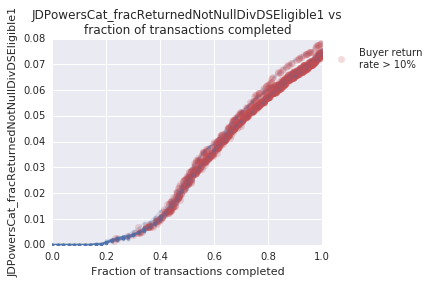

########################################
Category column:    JDPowersCat
Transaction column: JDPowersCat_numTransactions
Fraction column:    JDPowersCat_fracReturned1DivReturnedNotNull
Timestamp: 2017-02-28T07:23:22GMT


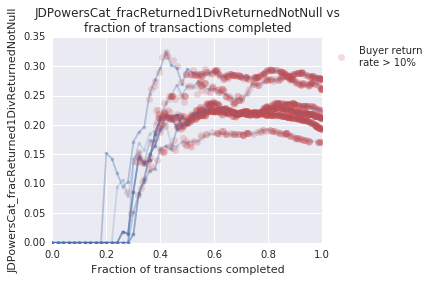

########################################
Category column:    JDPowersCat
Transaction column: JDPowersCat_numTransactions
Fraction column:    JDPowersCat_fracReturnedasm1DivTransactions
Timestamp: 2017-02-28T07:23:44GMT


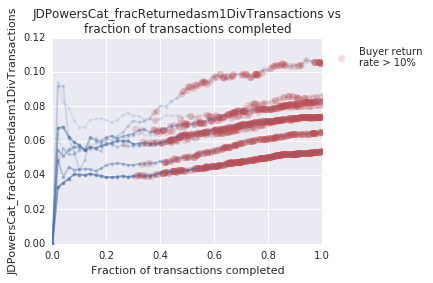

In [12]:
# re-initialize matplotlib inline in case handle dropped
%matplotlib inline
demo.app_predict.predict.plot_eda(
    df=df,
    columns=sorted(df.columns[np.logical_or(df.dtypes=='int64', df.dtypes=='float64')]),
    path_plot_dir=os.path.join(path_data_dir, 'plot_eda'))

## Heuristic

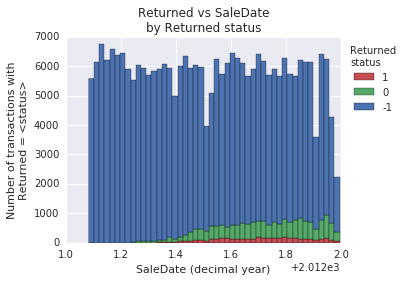

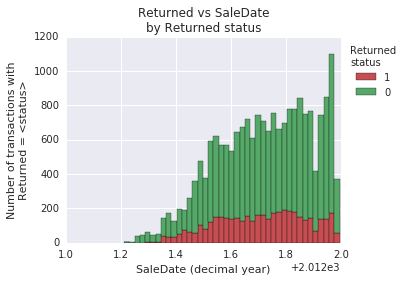

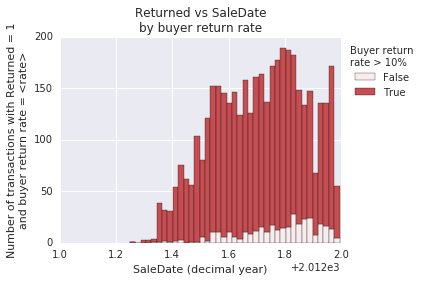

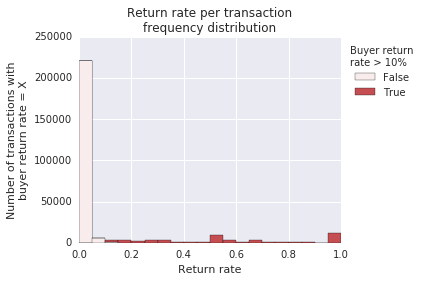

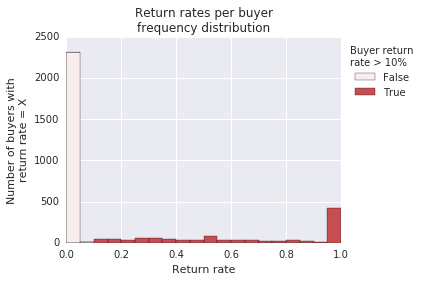

In [13]:
# re-initialize matplotlib inline in case handle dropped
%matplotlib inline
demo.app_predict.predict.plot_heuristic(
    df=df,
    path_plot_dir=os.path.join(path_data_dir, 'plot_heuristic'))

### Test heuristic

Note: The heuristic isn't "trained", just calculated (no iterations).
TODO:
* Bootstrap to get uncertainties.
* **Make list of bad dealers**
* **Predict 'Returned'**: P(Returned < 0.1) then P(Dealer_retrate < 0.1)
* Don't remove Returned == -1 since that means not DealShield approved or yes DealShield approved but not purchased.

In [15]:
buyer_retrate = 'BuyerID_fracReturned1DivReturnedNotNull'
buyer_retrate_max = 0.1

In [71]:
date_range = pd.date_range(start=df['SaleDate'].min(), end=df['SaleDate'].max(), freq='M')
df_modl = df.loc[
    np.logical_and(
        date_range[0] <= df['SaleDate'],
        df['SaleDate'] < date_range[1])].copy()
df_orig = df.loc[
    np.logical_and(
        date_range[0] <= df['SaleDate'],
        df['SaleDate'] < date_range[1])].copy()
buyers = np.asarray([])
buyers_prohibited = dict() # key: (df_train['SaleDate'].min(), df_train['SaleDate'].max())
transactions_affected = dict() # key: (df_test['SaleDate'].min(), df_test['SaleDate'].max())
retrates_modl = dict() # key: (df_modl['SaleDate'].min(), df_modl['SaleDate'].max())
retrates_orig = dict() # key: (df_orig['SaleDate'].min(), df_orig['SaleDate'].max())
for idx in range(len(date_range)-2):
    print('#'*40)
    print('Timestamp:', time.strftime(r'%Y-%m-%dT%H:%M:%S%Z', time.gmtime()))
    # Define data sets.
    (saledate_train_min, saledate_train_max) = (date_range[idx],   date_range[idx+1])
    (saledate_test_min,  saledate_test_max)  = (date_range[idx+1], date_range[idx+2])
    (saledate_eval_min,  saledate_eval_max)  = (date_range[idx+1], date_range[idx+2])
    df_train = df_modl.loc[
        np.logical_and(
            saledate_train_min <= df['SaleDate'],
            df['SaleDate'] < saledate_train_max)].copy()
    df_test = df.loc[
        np.logical_and(
            saledate_test_min <= df['SaleDate'],
            df['SaleDate'] < saledate_test_max)].copy()
    df_eval = df.loc[
        np.logical_and(
            saledate_eval_min <= df['SaleDate'],
            df['SaleDate'] < saledate_eval_max)].copy()
    # Prohibit purchase of DealShield in test data:
    # If prohibiting purchase of DealShield,
    # then for prohibed buyers, set DSEligible = 0 and Returned = -1
    buyers = np.unique(
        np.append(
            buyers,
            df_train.loc[df_train[buyer_retrate] > buyer_retrate_max, 'BuyerID'].unique()))
    buyers_prohibited[(df_train['SaleDate'].min(), df_train['SaleDate'].max())] = buyers
    tfmask = np.logical_and(
        np.logical_and(
            df_test['SaleDate'] > df_train['SaleDate'].max(),
            df_test['BuyerID'].isin(buyers)),
        df_test['DSEligible'] == 1)
    transactions_affected[(df_test['SaleDate'].min(), df_test['SaleDate'].max())] = tfmask.loc[tfmask].index
    df_test.loc[tfmask, 'DSEligible'] = 0
    df_test.loc[tfmask, 'Returned'] = -1
    # Update calculated features.
    df_modl = df_modl.append(df_test)
    df_modl = demo.app_predict.predict.update_features(df=df_modl)
    df_orig = df_orig.append(df_eval)
    # Calculate return rates.
    retrate_modl = sum(df_modl['Returned']==1)/sum(df_modl['Returned']!=-1)
    retrate_orig = sum(df_orig['Returned']==1)/sum(df_orig['Returned']!=-1)
    retrates_modl[(df_modl['SaleDate'].min(), df_modl['SaleDate'].max())] = retrate_modl
    retrates_orig[(df_orig['SaleDate'].min(), df_orig['SaleDate'].max())] = retrate_orig
    print('Evaluation time span:', df_orig['SaleDate'].min(), df_orig['SaleDate'].max())
    print('Model return rate:   ', retrate_modl)
    print('Original return rate:', retrate_orig)

########################################
Timestamp: 2017-02-28T16:39:29GMT
Evaluation time span: 2013-01-31 00:00:00 2013-03-30 00:00:00
Model return rate:    0.0
Original return rate: 0.0
########################################
Timestamp: 2017-02-28T16:39:33GMT
Evaluation time span: 2013-01-31 00:00:00 2013-04-29 00:00:00
Model return rate:    0.0341463414634
Original return rate: 0.0341463414634
########################################
Timestamp: 2017-02-28T16:39:40GMT
Evaluation time span: 2013-01-31 00:00:00 2013-05-30 00:00:00
Model return rate:    0.178614823815
Original return rate: 0.183894230769
########################################
Timestamp: 2017-02-28T16:39:50GMT
Evaluation time span: 2013-01-31 00:00:00 2013-06-29 00:00:00
Model return rate:    0.199783432593
Original return rate: 0.210649229332
########################################
Timestamp: 2017-02-28T16:40:01GMT
Evaluation time span: 2013-01-31 00:00:00 2013-07-30 00:00:00
Model return rate:    0.20170212766
Ori

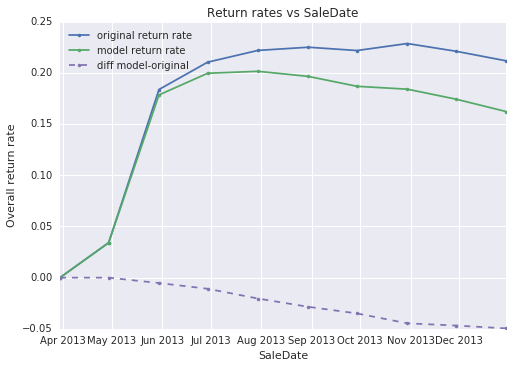

In [74]:
# Overall return rate is Returned==1 / (Returned not null)

(xvals_orig, yvals_orig) = zip(*[(key[1], val) for (key, val) in sorted(retrates_orig.items())])
(xvals_modl, yvals_modl) = zip(*[(key[1], val) for (key, val) in sorted(retrates_modl.items())])
(xvals_diff, yvals_diff) = (xvals_orig, np.subtract(yvals_modl, yvals_orig))
plt.plot(
    xvals_orig, yvals_orig, marker='.', linestyle='-',
    color=sns.color_palette()[0], label='original return rate')
plt.plot(
    xvals_modl, yvals_modl, marker='.', linestyle='-',
    color=sns.color_palette()[1], label='model return rate')
plt.plot(
    xvals_diff, yvals_diff, marker='.', linestyle='--',
    color=sns.color_palette()[3], label='diff model-original')
plt.title("Return rates vs SaleDate")
plt.xlabel("SaleDate")
plt.ylabel("Overall return rate")
plt.legend(loc='upper left')
plt.show()

In [73]:
buyer_counts = collections.Counter()
for (key, val) in buyers_prohibited.items():
    buyer_counts.update(val)
buyer_counts.most_common(n=10)

[('61773', 8),
 ('62851', 8),
 ('16640', 8),
 ('20718', 8),
 ('179863', 8),
 ('46857', 8),
 ('36633', 7),
 ('19332', 7),
 ('92311', 7),
 ('20481', 7)]

########################################
BuyerID: 272356
########################################
BuyerID: 328701
########################################
BuyerID: 179863
########################################
BuyerID: 61773


/opt/conda/lib/python3.5/site-packages/matplotlib/axes/_base.py:3045: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1, top=1
  'bottom=%s, top=%s') % (bottom, top))


########################################
BuyerID: 62851
########################################
BuyerID: 16640
########################################
BuyerID: 20718
########################################
BuyerID: 46857


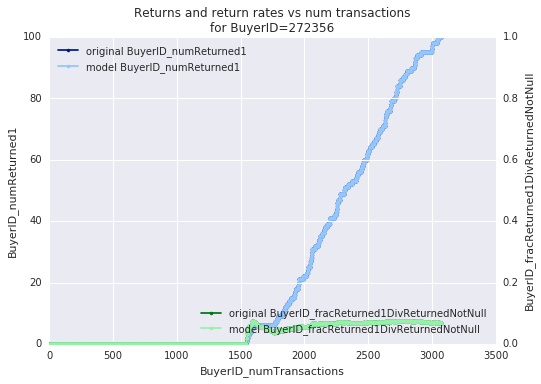

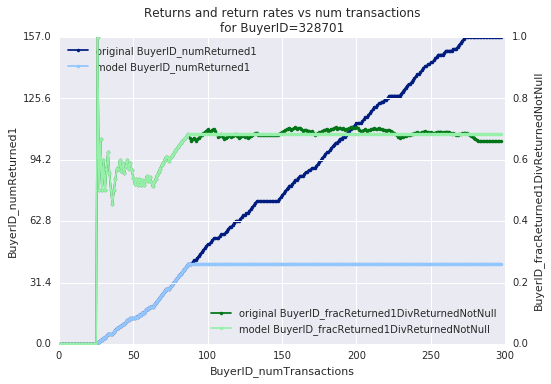

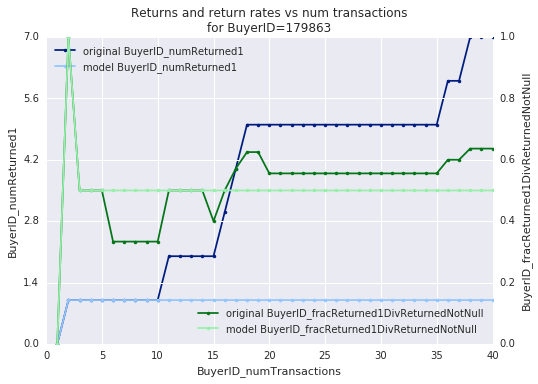

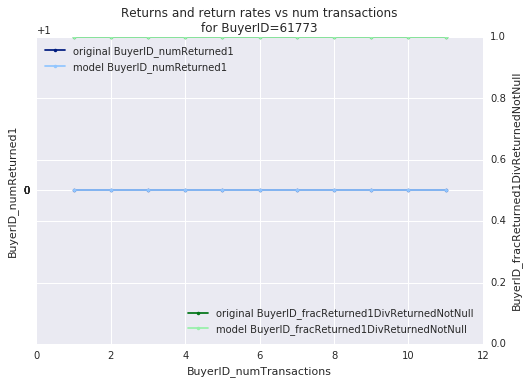

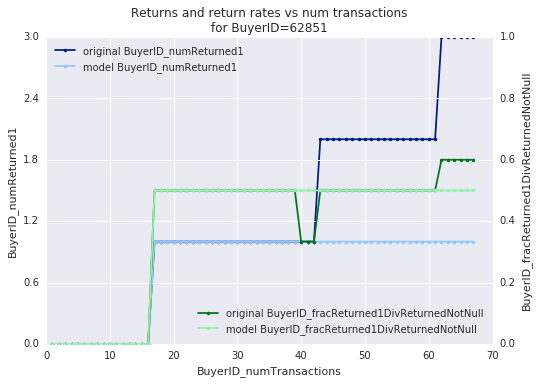

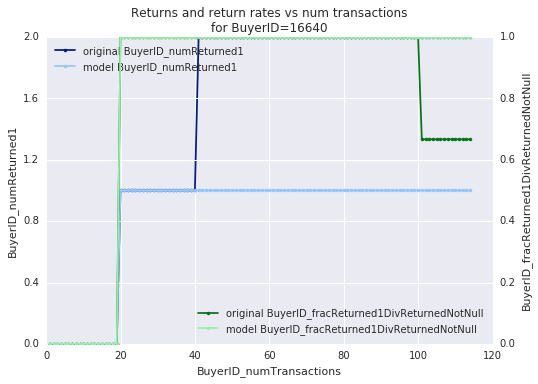

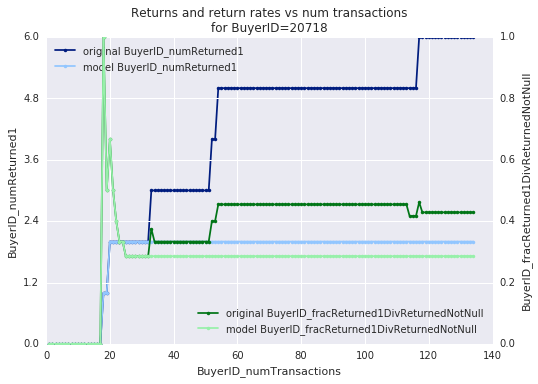

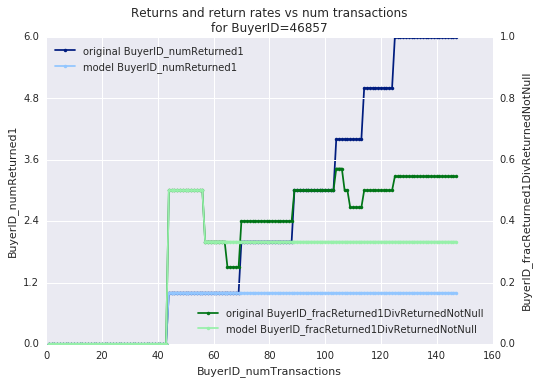

In [75]:
# Overall return rate is Returned==1 / (Returned not null)
# Note: to get buyerid with col max: df_orig.loc[df_orig[col].argmax(), 'BuyerID']

buyerids = [
    '272356', # buyer with max BuyerID_numReturnedNotNull (max accepted DealShield)
    '328701', # buyer with max BuyerID_numReturned1 (max returns)
    '179863', # buyer with max BuyerID_fracReturned1DivReturnedNotNull (max return rate)
    '61773', '62851', '16640', '20718', '46857'] # buyers frequently prohibited]

for buyerid in buyerids:
    print('#'*40)
    print('BuyerID:', buyerid)

    fig = plt.figure()
    ax0 = fig.add_subplot(111)
    ax0.set_title(textwrap.dedent("""\
        Returns and return rates vs num transactions
        for BuyerID={buyerid}""".format(buyerid=buyerid)))
    ax0.set_xlabel('BuyerID_numTransactions')

    ax0.set_ylabel('BuyerID_numReturned1')
    lns0 = list()
    xvals_orig = df_orig.loc[df_orig['BuyerID']==buyerid, 'BuyerID_numTransactions'].values
    yvals0_orig = df_orig.loc[df_orig['BuyerID']==buyerid, 'BuyerID_numReturned1'].values
    lns0 += ax0.plot(
        xvals_orig, yvals0_orig, marker='.', linestyle='-', 
        color=sns.color_palette(palette='dark')[0], label='original BuyerID_numReturned1')
    xvals_modl = df_modl.loc[df_modl['BuyerID']==buyerid, 'BuyerID_numTransactions'].values
    yvals0_modl = df_modl.loc[df_modl['BuyerID']==buyerid, 'BuyerID_numReturned1'].values
    lns0 += ax0.plot(
        xvals_modl, yvals0_modl, marker='.', linestyle='-', 
        color=sns.color_palette(palette='pastel')[0], label='model BuyerID_numReturned1')
    ylim0 = (
        min(min(yvals0_orig), min(yvals0_modl)),
        max(max(max(yvals0_orig), max(yvals0_modl)), 1))
    ax0.set_ylim(ylim0)
    nticks = 6
    ax0.set_yticks(np.linspace(start=ylim0[0], stop=ylim0[1], num=nticks, endpoint=True))
    ax0.legend(lns0, [ln.get_label() for ln in lns0], loc='upper left')

    ax1 = ax0.twinx()
    ax1.set_ylabel(buyer_retrate)
    lns1 = list()
    yvals1_orig = df_orig.loc[df_orig['BuyerID']==buyerid, buyer_retrate].values
    lns1 += ax1.plot(
        xvals_orig, yvals1_orig, marker='.', linestyle='-', 
        color=sns.color_palette(palette='dark')[1], label='original '+buyer_retrate)
    yvals1_modl = df_modl.loc[df_modl['BuyerID']==buyerid, buyer_retrate].values
    lns1 += ax1.plot(
        xvals_modl, yvals1_modl, marker='.', linestyle='-', 
        color=sns.color_palette(palette='pastel')[1], label='model '+buyer_retrate)
    ylim1 = (0, 1)
    ax1.set_ylim(ylim1)
    ax1.set_yticks(np.linspace(start=ylim1[0], stop=ylim1[1], num=nticks, endpoint=True))
    ax1.legend(lns1, [ln.get_label() for ln in lns1], loc='lower right')
    plt.show(fig)

In [72]:
df_modl.loc[
    df['BuyerID'] == '61773',
    ['SaleDate', 'DSEligible', 'Returned', 'BuyerID_numTransactions', 'BuyerID_numReturned1']]

SaleDate  DSEligible  Returned  BuyerID_numTransactions  \
71151  2013-04-23           1         1                        1   
89759  2013-05-14           0        -1                        2   
111622 2013-06-11           0        -1                        3   
124534 2013-06-25           0        -1                        4   
146353 2013-07-23           0        -1                        5   
146354 2013-07-23           0        -1                        6   
146359 2013-07-23           0        -1                        7   
176331 2013-08-27           0        -1                        8   
183006 2013-09-03           0        -1                        9   
260708 2013-12-05           0        -1                       10   
260860 2013-12-05           0        -1                       11   

        BuyerID_numReturned1  
71151                      1  
89759                      1  
111622                     1  
124534                     1  
146353                     1  
146354                     1  
146359                     1  
176331                     1  
183006                     1  
260708                     1  
260860                     1

In [ ]:
# MAKE UPDATE METHOD

In [97]:
df_modl_old = df_modl.copy()
df_orig_old = df_orig.copy()

In [106]:
%pdb on

Automatic pdb calling has been turned ON


In [110]:
date_range = pd.date_range(start=df['SaleDate'].min(), end=df['SaleDate'].max(), freq='M')
df_modl = df.loc[
    np.logical_and(
        date_range[0] <= df['SaleDate'],
        df['SaleDate'] < date_range[1])].copy()
df_orig = df.loc[
    np.logical_and(
        date_range[0] <= df['SaleDate'],
        df['SaleDate'] < date_range[1])].copy()
buyers = np.asarray([])
buyers_prohibited = dict() # key: (df_train['SaleDate'].min(), df_train['SaleDate'].max())
transactions_affected = dict() # key: (df_test['SaleDate'].min(), df_test['SaleDate'].max())
retrates_modl = dict() # key: (df_modl['SaleDate'].min(), df_modl['SaleDate'].max())
retrates_orig = dict() # key: (df_orig['SaleDate'].min(), df_orig['SaleDate'].max())
for idx in range(len(date_range)-2):
    print('#'*40)
    print('Timestamp:', time.strftime(r'%Y-%m-%dT%H:%M:%S%Z', time.gmtime()))
    # Define data sets.
    (saledate_train_min, saledate_train_max) = (date_range[idx],   date_range[idx+1])
    (saledate_test_min,  saledate_test_max)  = (date_range[idx+1], date_range[idx+2])
    (saledate_eval_min,  saledate_eval_max)  = (date_range[idx+1], date_range[idx+2])
    df_train = df_modl.loc[
        np.logical_and(
            saledate_train_min <= df['SaleDate'],
            df['SaleDate'] < saledate_train_max)].copy()
    df_test = df.loc[
        np.logical_and(
            saledate_test_min <= df['SaleDate'],
            df['SaleDate'] < saledate_test_max)].copy()
    df_eval = df.loc[
        np.logical_and(
            saledate_eval_min <= df['SaleDate'],
            df['SaleDate'] < saledate_eval_max)].copy()
    # Prohibit purchase of DealShield in test data:
    # If prohibiting purchase of DealShield,
    # then for prohibed buyers, set DSEligible = 0 and Returned = -1
    buyers = np.unique(
        np.append(
            buyers,
            df_train.loc[df_train[buyer_retrate] > buyer_retrate_max, 'BuyerID'].unique()))
    buyers_prohibited[(df_train['SaleDate'].min(), df_train['SaleDate'].max())] = buyers
    tfmask = np.logical_and(
        np.logical_and(
            df_test['SaleDate'] > df_train['SaleDate'].max(),
            df_test['BuyerID'].isin(buyers)),
        df_test['DSEligible'] == 1)
    transactions_affected[(df_test['SaleDate'].min(), df_test['SaleDate'].max())] = tfmask.loc[tfmask].index
    df_test.loc[tfmask, 'DSEligible'] = 0
    df_test.loc[tfmask, 'Returned'] = -1
    # Update calculated features.
    df_modl = demo.app_predict.predict.update_features_append(df_prev=df_modl, df_next=df_test)
    df_orig = df_orig.append(df_eval)
    # Calculate return rates.
    retrate_modl = sum(df_modl['Returned']==1)/sum(df_modl['Returned']!=-1)
    retrate_orig = sum(df_orig['Returned']==1)/sum(df_orig['Returned']!=-1)
    retrates_modl[(df_modl['SaleDate'].min(), df_modl['SaleDate'].max())] = retrate_modl
    retrates_orig[(df_orig['SaleDate'].min(), df_orig['SaleDate'].max())] = retrate_orig
    print('Evaluation time span:', df_orig['SaleDate'].min(), df_orig['SaleDate'].max())
    print('Model return rate:   ', retrate_modl)
    print('Original return rate:', retrate_orig)

########################################
Timestamp: 2017-02-28T18:46:33GMT
Evaluation time span: 2013-01-31 00:00:00 2013-03-30 00:00:00
Model return rate:    0.0
Original return rate: 0.0
########################################
Timestamp: 2017-02-28T18:46:38GMT
Evaluation time span: 2013-01-31 00:00:00 2013-04-29 00:00:00
Model return rate:    0.0341463414634
Original return rate: 0.0341463414634
########################################
Timestamp: 2017-02-28T18:46:45GMT
Evaluation time span: 2013-01-31 00:00:00 2013-05-30 00:00:00
Model return rate:    0.178614823815
Original return rate: 0.183894230769
########################################
Timestamp: 2017-02-28T18:46:53GMT
Evaluation time span: 2013-01-31 00:00:00 2013-06-29 00:00:00
Model return rate:    0.199783432593
Original return rate: 0.210649229332
########################################
Timestamp: 2017-02-28T18:47:05GMT
Evaluation time span: 2013-01-31 00:00:00 2013-07-30 00:00:00
Model return rate:    0.20170212766
Ori

In [111]:
(df_modl == df_modl_old).all().all()

True

In [ ]:
# REDO BELOW

In [ ]:
# TODO
# Determine which features are categorical and plot.
# Features are considered "categorical" if
# num_unique_feature_values < min(num_unique_id_values, num_unique_target_values)
(df_ftrs, ds_trg) = (step.s2.dfs.df_features_model, step.s2.dfs.ds_target_model)
(nuniq_uid, nuniq_trg) = (len(df_ftrs['SERIALNO'].unique()), len(ds_trg.unique()))
nuniq_min = min(nuniq_uid, nuniq_trg)
(ftr_nuniq, nuniq_nftrs, cat_ftrs) = (dict(), collections.defaultdict(int), list())
for ftr in df_ftrs.columns:
    ftr_nuniq[ftr] = len(df_ftrs[ftr].unique())
for (ftr, nuniq) in ftr_nuniq.items():
    nuniq_nftrs[nuniq] += 1
    if 1 < nuniq < nuniq_min:
        cat_ftrs.append(ftr)
nuniq_nftrs = np.asarray(sorted(nuniq_nftrs.items()))
tfmask = np.logical_and(1 < nuniq_nftrs[:, 0], nuniq_nftrs[:, 0] < nuniq_min)
nuniq_nftrs_cat = nuniq_nftrs[tfmask]
if not np.sum(nuniq_nftrs_cat[:, 1]) == len(cat_ftrs):
    raise AssertionError(
        ("Program error. The tallies of categorical features do not match.\n" +
         "Required: np.sum(nuniq_nftrs_cat[:, 1]) == len(cat_ftrs)\n" +
         "Given: {lhs} == {rhs}").format(
            lhs=np.sum(nuniq_nftrs_cat[:, 1]), rhs=len(cat_ftrs)))
print(
    ("Features are considered 'categorical' if num_unique_feature_values\n" +
     "    < min(num_unique_id_values ({uid}), num_unique_target_values ({trg}))\n" +
     "    = min({nuid}, {ntrg}) = {nmin}\n" +
     "Percent of features that are categorical: {frac:.1%}").format(
        uid='SERIALNO', trg=step.s0.dfs.ds_target_model.name,
        nuid=nuniq_uid, ntrg=nuniq_trg, nmin=nuniq_min,
        frac=len(cat_ftrs)/len(df_ftrs.columns)))
plt.semilogx(
    nuniq_nftrs[:, 0], nuniq_nftrs[:, 1], marker='.', linestyle='-',
    color=sns.color_palette()[0], label='features')
plt.semilogx(
    nuniq_nftrs_cat[:, 0], nuniq_nftrs_cat[:, 1], marker='o', linestyle='',
    color=sns.color_palette(palette='dark')[0], label='categorical features')
plt.axvline(
    x=len(step.s2.dfs.ds_target_model.unique()),
    color=sns.color_palette()[1], label=step.s2.dfs.ds_target_model.name)
plt.axvline(
    x=len(step.s2.dfs.df_features_model['SERIALNO'].unique()),
    color=sns.color_palette()[2], label='SERIALNO')
plt.title("Number of feature vs number of unique values per feature")
plt.xlabel("Number of unique values per feature")
plt.ylabel("Number of features")
plt.legend(loc='upper center')
plt.show()